# Monte Carlo Nullpoint Approach - Code Description

This is the central code for looking at nullpoints under a Jupyter Notebooks framework

This is the python script for replicating the Bi,Spencer 2D stabilization technique with the intention of varying TI for Eq.3 to observe the TI related nullpoint - this code has the potential to look at a histogram for each TI value or to look at the standard deviation across the population for a range of TI values

# Import Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
# import mpld3
# mpld3.enable_notebook()

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Set Options

In [2]:
#Initial Options
histPlot = True
stdPlot = True
cNPlot = True
denPlot = True      #Plot all estimated signals against the true signal 

dModel = True      #This option enables for using the d1 and d2 based model

# Initialize Parameters and Arrays

In [3]:
#Assumed echo time points
TE_series = np.arange(8, 512, 8) #ms units

######All Fixed parameters for code
#Parameters held constant
c1 = 0.5
c2 = 0.5
T21 = 45
T22 = 100
T11 = 600
T12 = 1200

initParams = np.array([T11, T12, c1, c2, T21, T22])

#Bound used during NLLS to constrain the upper bound on T2 values
T2_bound = 1000

#Zoom Fits range
rad = 0.05 #percent radius around the zoom fits

#Information determing TI range
bothTI = True
TI_numPoints = 21
TI_betPoints = 5
TI_befPoints = 3
TI_lb = 0.93
TI_ub = 1.07
assert(TI_ub>TI_lb)

#Parameters that dictate process related features
iterCount = 10000 #number of iterations that curveFit is applied
SNR = 1000

#Preparing TI array to loop through
alpha_array = np.linspace(TI_lb,TI_ub,TI_numPoints)
TI1star = np.log(2)*(T11)
TI1_array = alpha_array*TI1star

TI2star = np.log(2)*T12
TI2_array = alpha_array*TI2star

assert(TI1_array[np.size(TI1_array)-1] <= TI2_array[0])
bet_array = np.linspace(TI1_array[np.size(TI1_array)-1],TI2_array[0],TI_betPoints+2)
bet_array = bet_array[1:np.size(bet_array)-1]
assert(np.size(bet_array)==TI_betPoints)

bef_array = np.linspace(TI1_array[0]*2/3,TI1_array[0],TI_befPoints+1)
bef_array = bef_array[0:np.size(bef_array)-1]

if bothTI:
    TI_array = [*bef_array, *TI1_array, *bet_array, *TI2_array]
    betFill = np.zeros(TI_betPoints)
    befFill = np.zeros(TI_befPoints)
    alpha_array = [*befFill, *alpha_array, *betFill, *alpha_array]
else:
    TI_array = TI1_array

assert(np.size(TI_array) == np.size(alpha_array))

#Initializing all the storage matrices
#Storing all strings associated with titles
MonoTitle = ['d', 'T2']
ParamTitle_4p = ['d1', 'd2', 'T21', 'T22']
ParamTitle_6p = ['T11','T12','c1','c2','T21','T22']

#List estimated Param names
if dModel:
    estParams = ParamTitle_4p
else:
    estParams = ParamTitle_6p[2:np.size(ParamTitle_6p)]

round_Params = [round(num, 2) for num in initParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

#Initializing where all parameter values are stored
paramStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(estParams)])
paramStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(MonoTitle)])
avgPStore = np.zeros([np.size(TI_array), np.size(estParams)])

#Storing all the estimated signals for each iteration and TI array
sigStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])
sigStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])

#All standard deviation of parameter values matrices
stdStore = np.zeros([np.size(TI_array),np.size(estParams)])
mono_std = np.zeros([np.size(TI_array),np.size(MonoTitle)])
std2Store = np.zeros([np.size(TI_array),np.size(estParams)])

#All error related matrices
RSS_Store = np.zeros([np.size(TI_array),iterCount])
errStore = np.zeros([np.size(TI_array),iterCount])
RSS_Store_1E = np.zeros([np.size(TI_array),iterCount])
errStore_1E = np.zeros([np.size(TI_array),iterCount])

#Condition number related matrix
if dModel:
    CNStore = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_4p)])
    avgCNStore = np.zeros([np.size(TI_array), np.size(ParamTitle_4p)])
else:
    CNStore = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_6p)])
    avgCNStore = np.zeros([np.size(TI_array), np.size(ParamTitle_6p)])

#Count Rulebreakers
numRuleBreak = np.zeros(np.size(TI_array))

#Title String
details = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) +" :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
            '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[TI_befPoints]) + "," + str(alpha_array[np.size(alpha_array)-1]) +
            '):: Points: ' + str(np.size(alpha_array)))

# Define Functions

In [4]:
#Defining the function of interest
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def Jacobian_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dc1, dc2, dT11, dT12, dT21, dT22), axis = -1)
    return jacobian

def Jacobian_4p(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

# Build Curve Fitting Dataset

In [5]:
#Looping through all TI values in the TI_array
for k in trange(np.size(TI_array)):

    TI = TI_array[k]

    true_d1 = d_value(TI, c1, T11)
    true_d2 = d_value(TI, c2, T12)

    realParams_4p = np.array([true_d1, true_d2, T21, T22])

    realParams = np.array([c1,c2,T21,T22])

    trueDat_4p = S_biX_4p(TE_series, *realParams_4p)
    trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

    assert(np.allclose(trueDat,trueDat_4p))
        
    brokenRules = 0

    i = 0
    #while loop so that if a lowest parameter value isn't found then we just do it again
    while i < iterCount:

        #Determining the noise and add noise to data
        noiseSigma = 1/SNR
        noise = np.random.normal(0,noiseSigma,TE_series.size)
        noiseDat = trueDat + noise

        lb = (-1,-1,0,0)
        ub = (1,1,T2_bound,T2_bound)
        if dModel:
            init_p = realParams_4p
        else:
            init_p = realParams

        lb_1E = (-1,0)
        ub_1E = (1,T2_bound)
        init_p_1E = ((true_d1 + true_d2)/2 , (T21 + T22)/2)

        try:
            if dModel:
                popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub])
            else:
                popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_6p(t_dat,TI,T11,T12,p1,p2,p3,p4), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub])
            popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, noiseDat, p0 = init_p_1E, bounds = [lb_1E,ub_1E])
        except Exception as e:
            print(e)
            brokenRules += 1
            print("Rerunning this iteration = " + str(i))
            continue

        #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place
        if (popt_2E[3] < popt_2E[2]): #We want by convention to make sure 
            p_hold = popt_2E[0]
            popt_2E[0] = popt_2E[1]
            popt_2E[1] = p_hold
            p_hold = popt_2E[2]
            popt_2E[2] = popt_2E[3]
            popt_2E[3] = p_hold

        paramStore_2E[k,i,:] = popt_2E
        paramStore_1E[k,i,:] = popt_1E

        #Calculate Condition Number
        if dModel:
            B = Jacobian_4p(TE_series, *popt_2E)
        else:
            B = Jacobian_6p(TE_series, TI, T11, T12, *popt_2E) 
        covP = np.dot(B.T,B) #*noiseSigma**2

        CN_params = np.reshape(np.diag(covP),(1,-1))
        CNStore[k,i,:] = CN_params

        #Calculate Residual Sum of Squares (RSS) of 2E
        if dModel:
            est_Sig = S_biX_4p(TE_series, *popt_2E)
        else:
            est_Sig = S_biX_6p(TE_series,TI,T11,T12,*popt_2E)
        RSS_Store[k,i] = np.sum((trueDat - est_Sig)**2)
        errStore[k,i] = np.linalg.norm(trueDat - est_Sig, ord = 2)
        sigStore_2E[k,i,:] = est_Sig

        #Calculate Residual Sum of Squares (RSS) of 1E
        est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
        RSS_Store_1E[k,i] = np.sum((trueDat - est_Sig_1E)**2)
        errStore_1E[k,i] = np.linalg.norm(trueDat - est_Sig_1E, ord = 2)
        sigStore_1E[k,i,:] = est_Sig_1E

        i += 1 #iteration step

    numRuleBreak[k] = brokenRules
    avgCNStore[k,:] = np.reshape(np.mean(CNStore[k,:,:], axis = 0),(1,-1))
    avgPStore[k,:] = np.mean(paramStore_2E[k,:,:], axis = 0)
    stdStore[k,:] = np.std(paramStore_2E[k,:,:], axis = 0)
    std2Store[k,:] = np.var(paramStore_2E[k,:,:], axis = 0)**(1/2)
    mono_std[k,:] = np.std(paramStore_1E[k,:,:], axis = 0)

    # if histPlot:
    #     fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
    #     for ii in range(2):

    #         #Get a good bin size
    #         binData = paramStore_2E[:,[2*ii,2*ii+1]]
    #         binData = np.reshape(binData,-1)
    #         binW = (np.max(binData) - np.min(binData))/12
    #         binW = float('%.1g' % binW) #converts everything to a single significant figure
    #         binMin = 10**(np.floor(np.log10(np.min(binData))))
    #         binArray = np.arange(binMin, np.max(binData) + binW, binW)

    #         #Construct a nice figure of each of the two 
    #         ax[ii].hist(x=paramStore_2E[:,2*ii], bins=binArray, color='b', label = estParams[2*ii], alpha = 0.7)
    #         ax[ii].hist(x=paramStore_2E[:,2*ii+1], bins=binArray, color='g', label = estParams[2*ii+1], alpha = 0.7)
    #         ax[ii].set_xlabel('Param Value')
    #         ax[ii].set_ylabel('Count')
    #         ax[ii].axvline(x=realParams[2*ii], linewidth=1, label= 'True ' + estParams[2*ii], color='red')
    #         ax[ii].axvline(x=realParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='orange')
    #         ax[ii].legend()
    #         ax[ii].set_title('Parameter Histogram Comparison' + 
    #                     '\nTI1* = ' + str(round(TI1star,2)) + ' :: TI2* = ' + str(round(TI2star,2)) + 
    #                     '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) +
    #                     '\nTrue ' + estParams[2*ii] + '=' + str(round(realParams[2*ii],2)) + ' :: ' 
    #                     'True ' + estParams[2*ii+1] + '=' + str(round(realParams[2*ii+1],2)))
    #     fig.tight_layout()
    #     plt.show()

    # if denPlot:
    #     fig, ax = plt.subplots(2,2, figsize=(10,8), tight_layout=True)

    #     fig.suptitle('Fit Visualization' + 
    #                     '\nTI1* = ' + str(round(TI1star,2)) + ' :: TI2* = ' + str(round(TI2star,2)) + 
    #                     '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) + 
    #                     '\nParams (' + pTitleList + ') = ' + '('+ pList + ')')
        
    #     for rep in range(iterCount):
    #         ax[0,0].plot(TE_series, sigStore_2E[k,rep,:], color='r', alpha = 0.5)
    #         ax[0,1].plot(TE_series, sigStore_1E[k,rep,:], color='r', alpha = 0.5)

    #     ax[0,0].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
    #     ax[0,1].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)

    #     ax[0,0].set_xlabel("TE")
    #     ax[0,1].set_xlabel("TE")
    #     ax[0,0].set_ylabel("Signal")
    #     ax[0,1].set_ylabel("Signal")
    #     ax[0,0].set_title("Biexponential Fits")
    #     ax[0,1].set_title("Monoexponential Fits")

    #     ax[1,0].hist(x = (sigStore_2E[k,:,:] - trueDat), bins = 20)
    #     ax[1,1].hist(x = (sigStore_1E[k,:,:] - trueDat), bins = 20)

    #     ax[1,0].set_xlabel("Error")
    #     ax[1,1].set_xlabel("Error")
    #     ax[1,0].set_ylabel("Counts")
    #     ax[1,1].set_ylabel("Counts")
    #     ax[1,0].set_title("Biexponential Fits")
    #     ax[1,1].set_title("Monoexponential Fits")

    #     plt.show()

 18%|█▊        | 9/50 [22:43<2:09:01, 188.81s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2363


 20%|██        | 10/50 [27:11<2:22:06, 213.17s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 6637
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9444


 22%|██▏       | 11/50 [32:51<2:43:50, 252.06s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1819
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3769
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5448
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8844
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9973


 24%|██▍       | 12/50 [40:33<3:20:04, 315.92s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1014
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1118
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1166
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1784
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2229
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3429
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3613
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4157
Optimal parameters not found: The maximum number of func

 26%|██▌       | 13/50 [46:59<3:27:50, 337.04s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 80
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 251
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 499
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1155
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1426
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1906
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2011
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2150
Optimal parameters not found: The maximum number of function

 28%|██▊       | 14/50 [54:30<3:42:54, 371.51s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 344
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 344
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 572
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 602
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1172
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1371
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1436
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1560
Optimal parameters not found: The maximum number of function

 30%|███       | 15/50 [1:02:52<3:59:42, 410.93s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 297
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 371
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 526
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 572
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 574
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 650
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 690
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 778
Optimal parameters not found: The maximum number of function eva

 32%|███▏      | 16/50 [1:11:51<4:14:40, 449.42s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 23
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 120
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 432
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 486
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 708
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 747
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 802
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 847
Optimal parameters not found: The maximum number of function eval

 34%|███▍      | 17/50 [1:20:11<4:15:32, 464.61s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 58
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 101
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 202
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 235
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 258
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 320
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 361
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 418
Optimal parameters not found: The maximum number of function eval

 36%|███▌      | 18/50 [1:28:02<4:08:54, 466.71s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 30
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 191
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 235
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 315
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 366
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 371
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 373
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 423
Optimal parameters not found: The maximum number of function eval

 38%|███▊      | 19/50 [1:35:33<3:58:37, 461.84s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 153
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 167
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 178
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 196
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 224
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 441
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 447
Optimal parameters not found: The maximum number of function evalu

 40%|████      | 20/50 [1:42:08<3:40:52, 441.75s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 97
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 162
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 173
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 191
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 362
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 551
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 731
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 738
Optimal parameters not found: The maximum number of function eval

 42%|████▏     | 21/50 [1:48:07<3:21:30, 416.92s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 42
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 166
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 224
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 352
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 493
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 549
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 724
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 799
Optimal parameters not found: The maximum number of function eval

 44%|████▍     | 22/50 [1:53:35<3:02:08, 390.30s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 72
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 132
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 276
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 323
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 576
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 612
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 636
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 719
Optimal parameters not found: The maximum number of function eval

 46%|████▌     | 23/50 [1:58:26<2:42:10, 360.37s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9996
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 407
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 867
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 985
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1332
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1396
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1421
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1637
Optimal parameters not found: The maximum number of functio

 56%|█████▌    | 28/50 [2:09:34<58:00, 158.19s/it]  

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 9334


 58%|█████▊    | 29/50 [2:10:56<47:17, 135.13s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 357
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 477
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2659
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2986
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4381
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4893
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5253
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5891
Optimal parameters not found: The maximum number of functi

 60%|██████    | 30/50 [2:13:22<46:10, 138.54s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 647
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1019
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1174
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1445
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2750
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2888
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3046
Optimal parameters not found: The maximum number of function

 62%|██████▏   | 31/50 [2:16:24<47:57, 151.46s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 351
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1365
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1614
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1935
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2793
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2815
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2832
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3211
Optimal parameters not found: The maximum number of funct

 64%|██████▍   | 32/50 [2:19:47<50:07, 167.08s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 16
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 63
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 242
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 399
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1084
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2511
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3458
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3532
Optimal parameters not found: The maximum number of function e

 66%|██████▌   | 33/50 [2:23:43<53:10, 187.65s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 213
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 249
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 622
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 643
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 678
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 804
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1273
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1471
Optimal parameters not found: The maximum number of function e

 68%|██████▊   | 34/50 [2:28:18<57:02, 213.88s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 57
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 171
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 480
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 523
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 901
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 908
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1022
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1307
Optimal parameters not found: The maximum number of function ev

 70%|███████   | 35/50 [2:33:36<1:01:17, 245.17s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 29
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 506
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1296
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1582
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1756
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1864
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1952
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2175
Optimal parameters not found: The maximum number of functio

 72%|███████▏  | 36/50 [2:39:54<1:06:29, 284.94s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 83
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 248
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 922
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 985
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1214
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1325
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1377
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1832
Optimal parameters not found: The maximum number of function 

 74%|███████▍  | 37/50 [2:47:00<1:10:54, 327.28s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 344
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1214
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1219
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1545
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1717
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2483
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3539
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3685
Optimal parameters not found: The maximum number of funct

 76%|███████▌  | 38/50 [2:54:32<1:12:54, 364.58s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1930
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2595
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3565
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5398
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7367
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7498
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7500
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7912
Optimal parameters not found: The maximum number of func

 78%|███████▊  | 39/50 [3:01:15<1:08:59, 376.30s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 798
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8446
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8731


 80%|████████  | 40/50 [3:06:57<1:00:57, 365.76s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 253


100%|██████████| 50/50 [3:26:50<00:00, 248.22s/it]  


# Plotting

### Histogram of Parameters

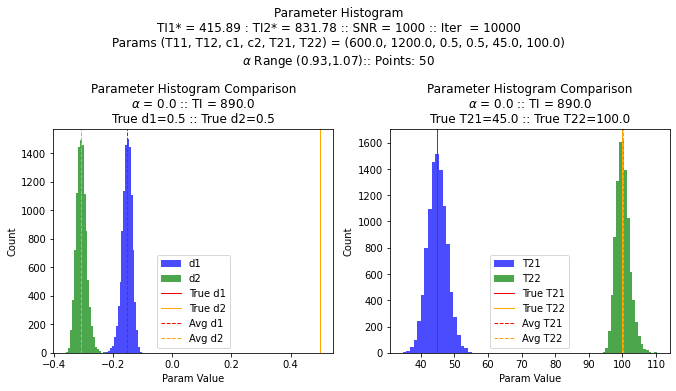

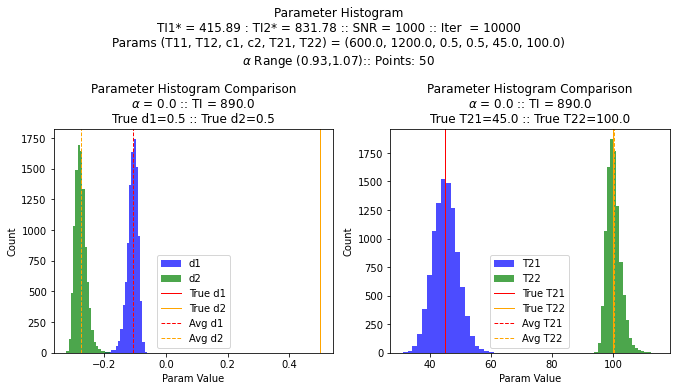

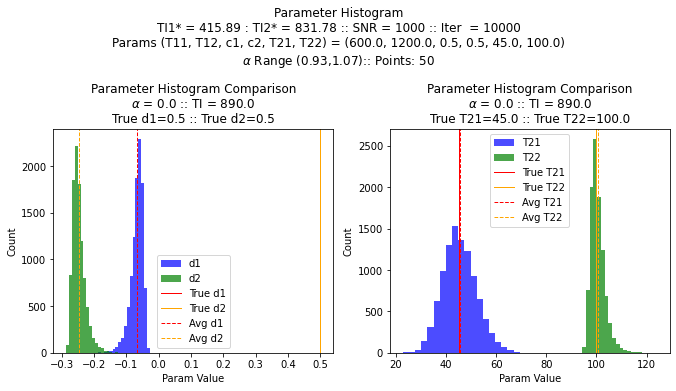

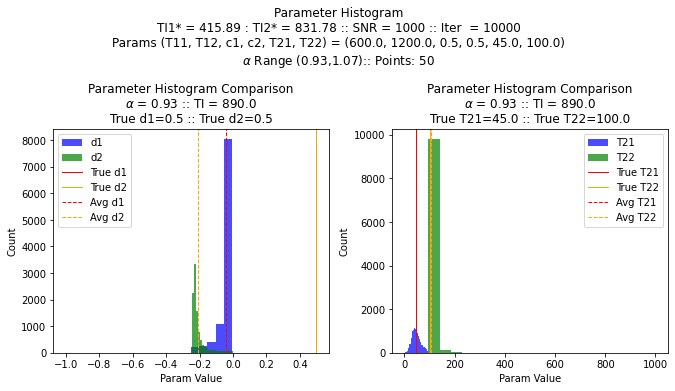

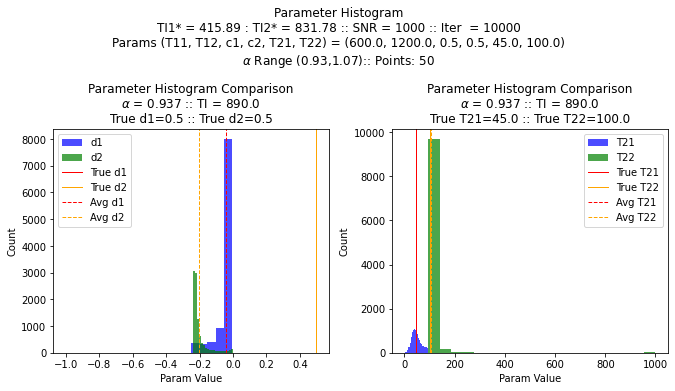

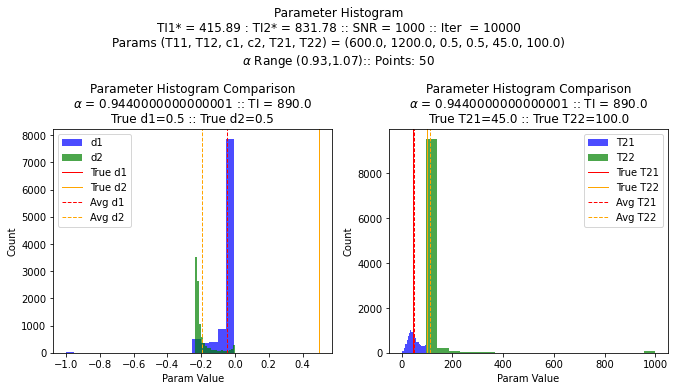

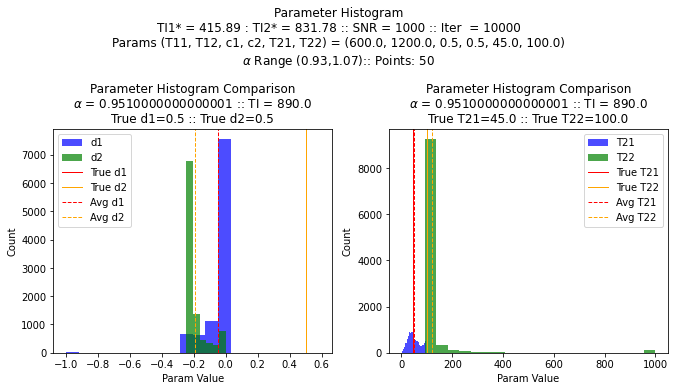

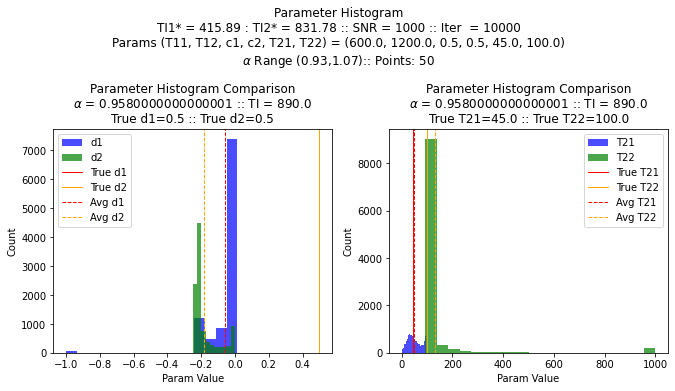

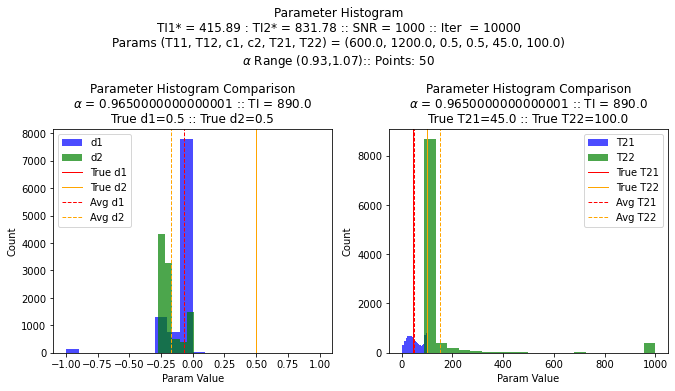

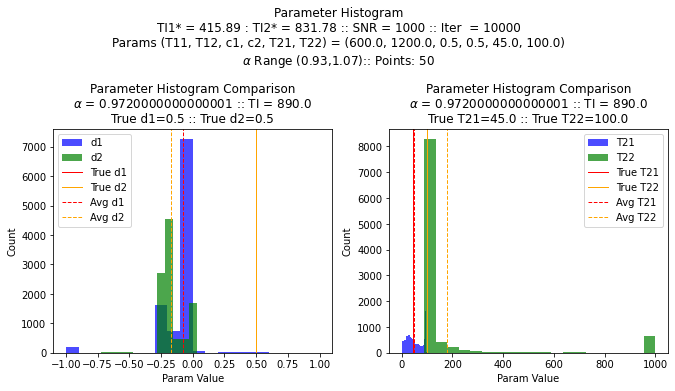

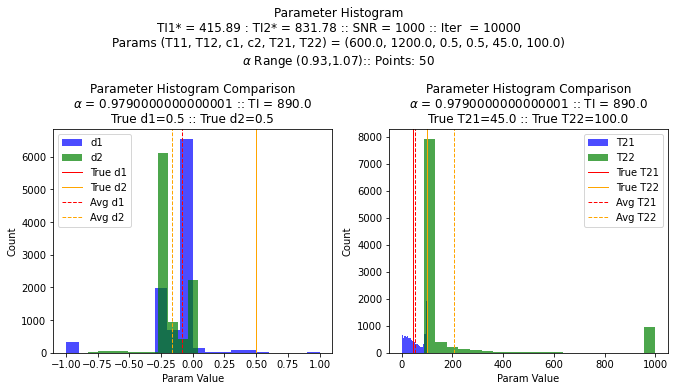

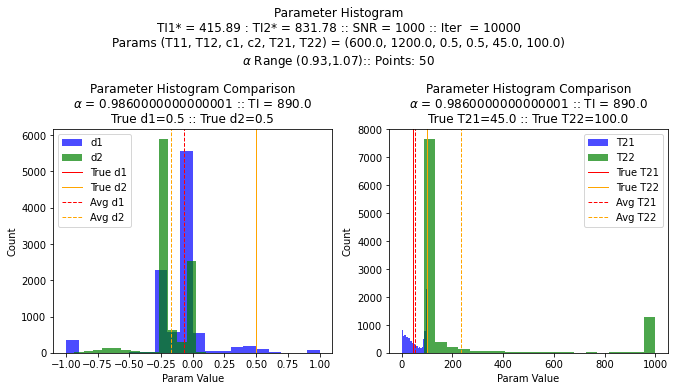

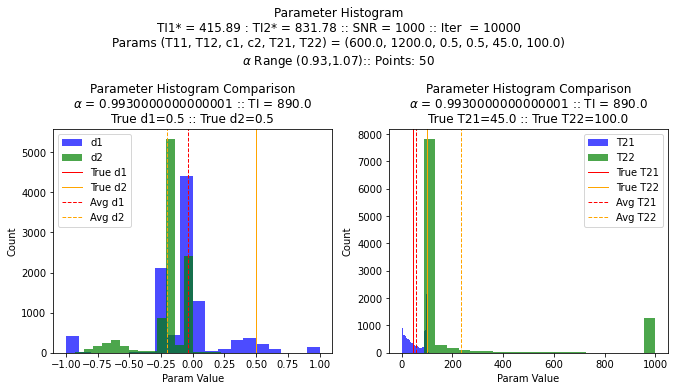

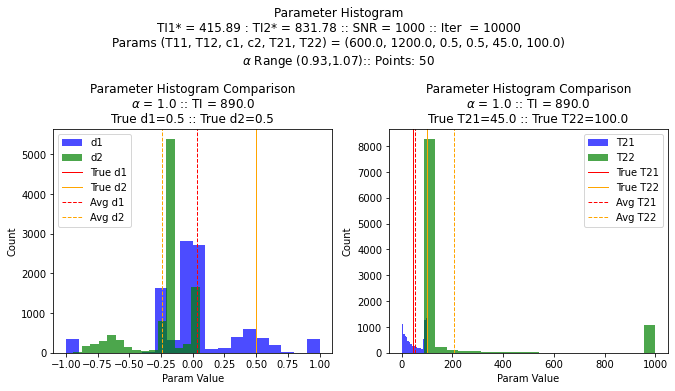

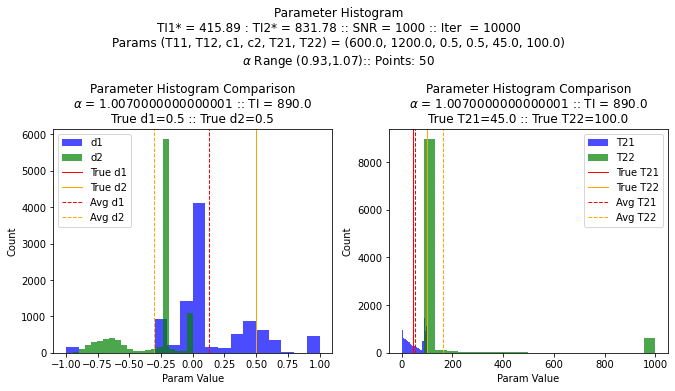

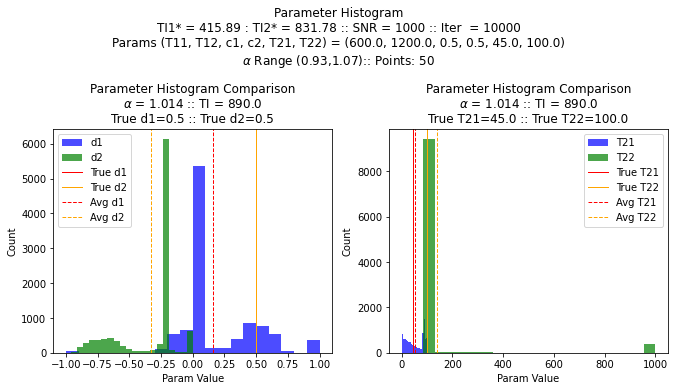

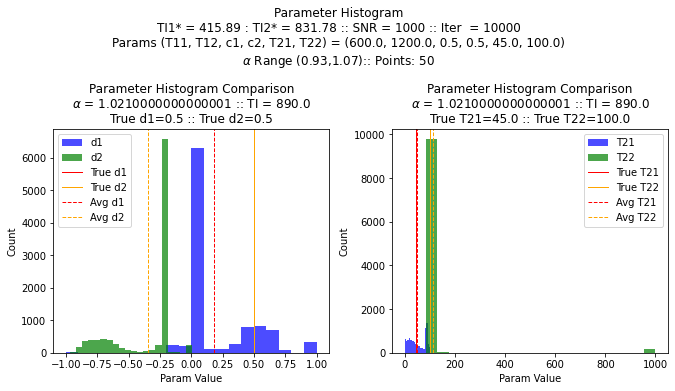

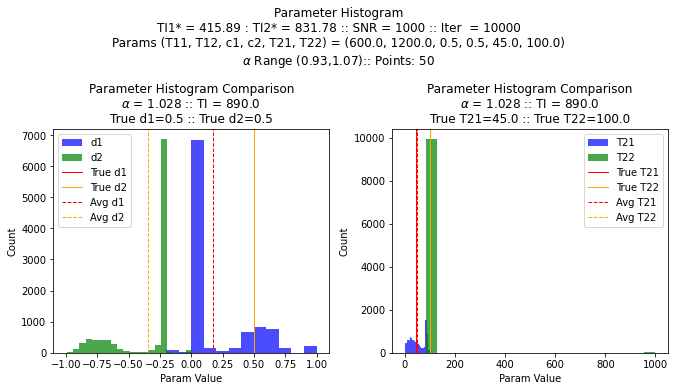

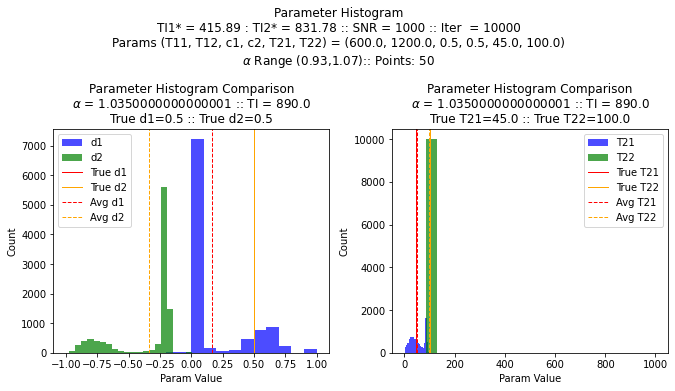

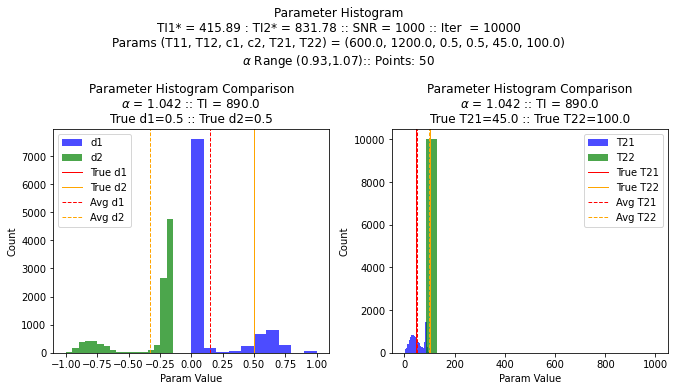

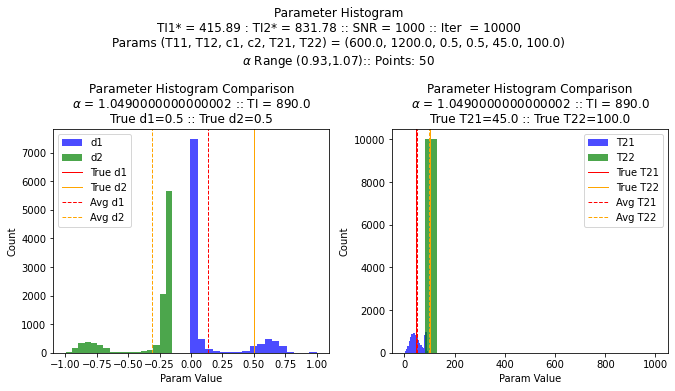

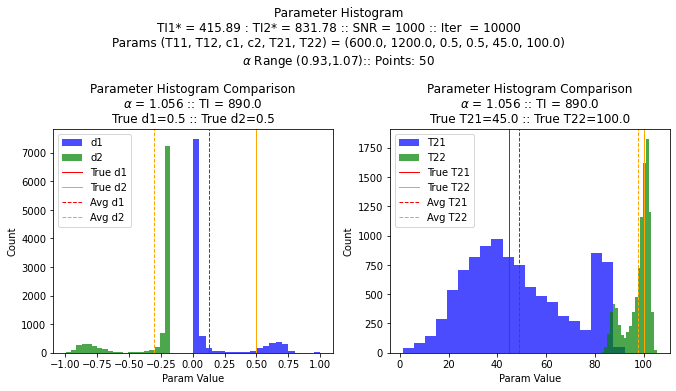

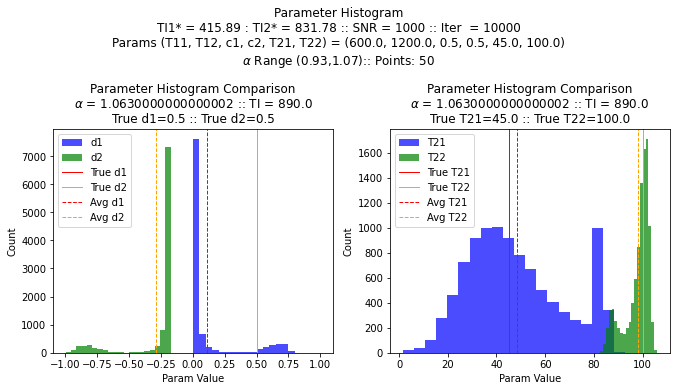

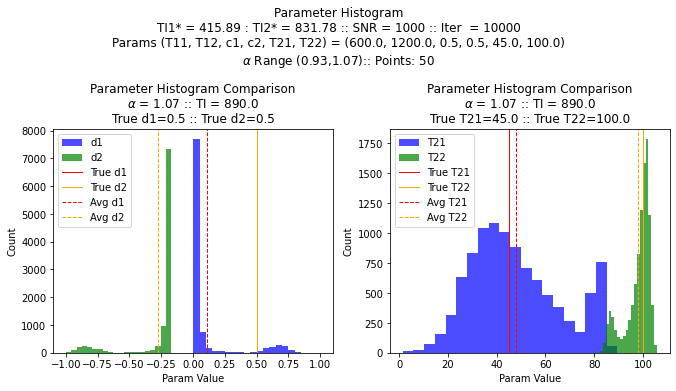

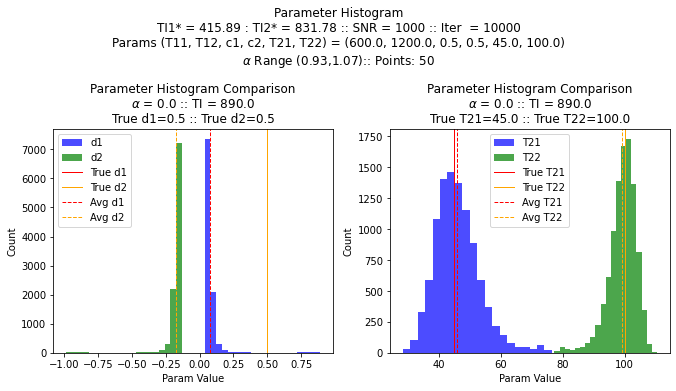

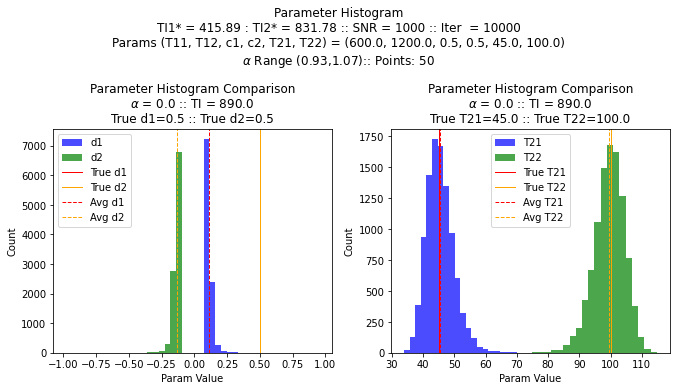

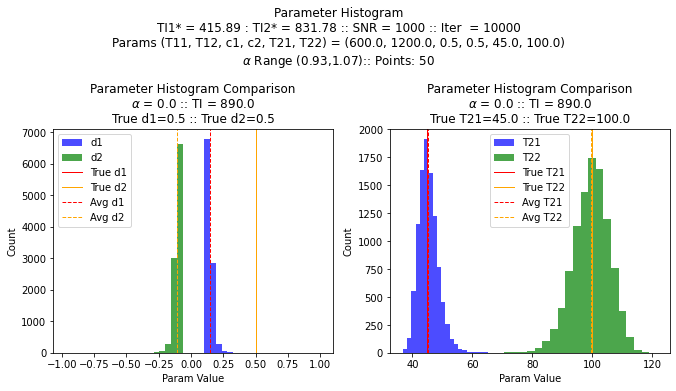

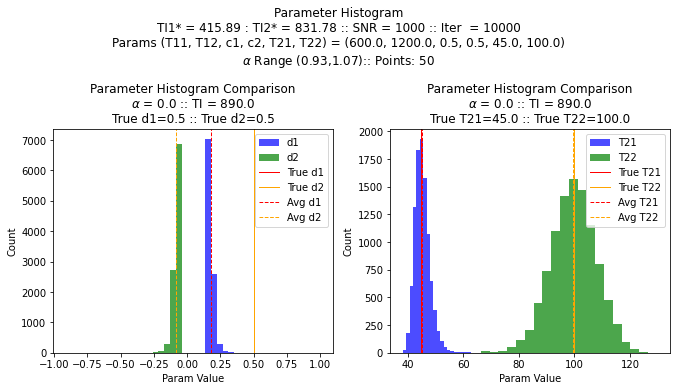

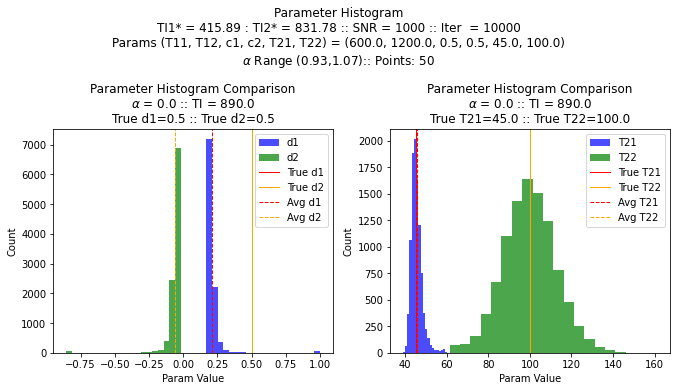

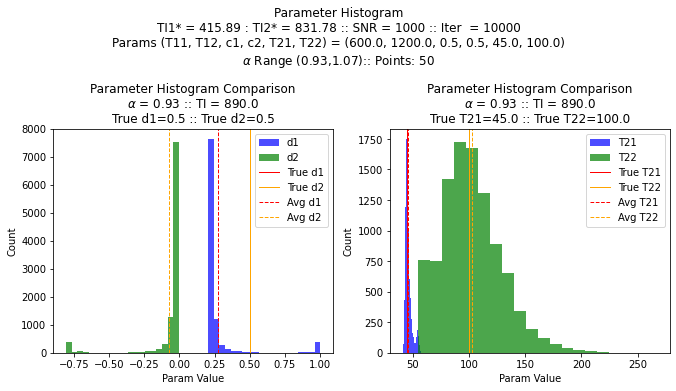

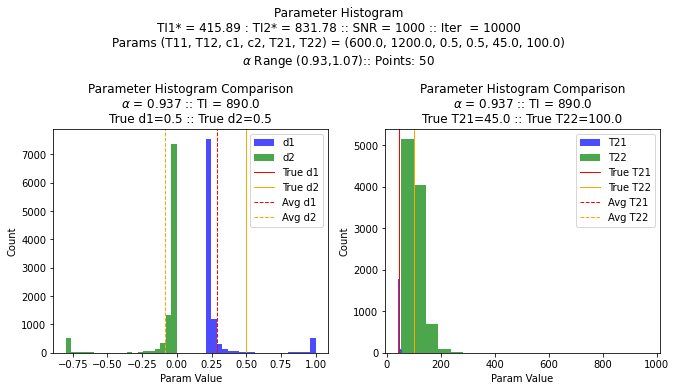

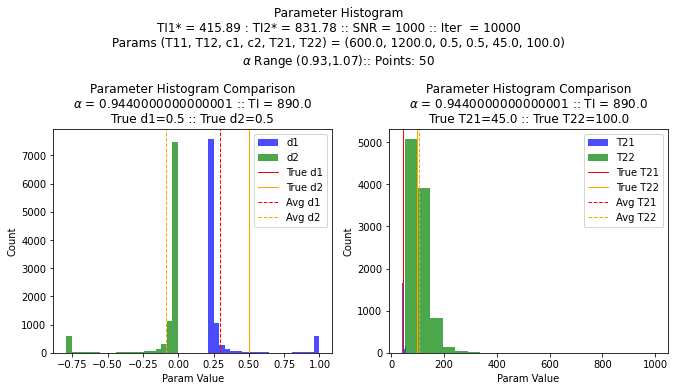

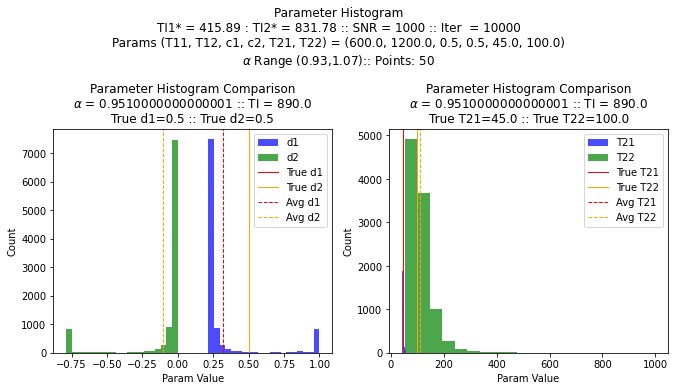

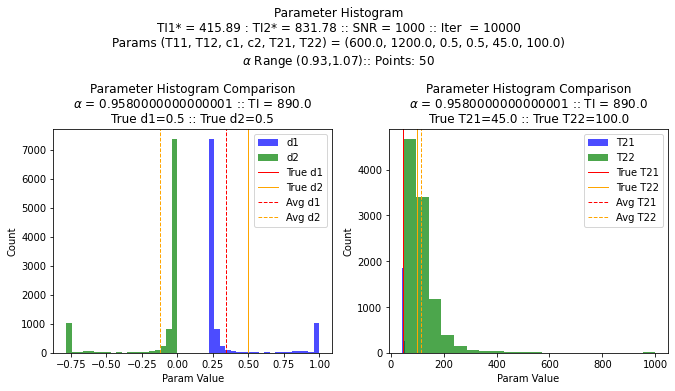

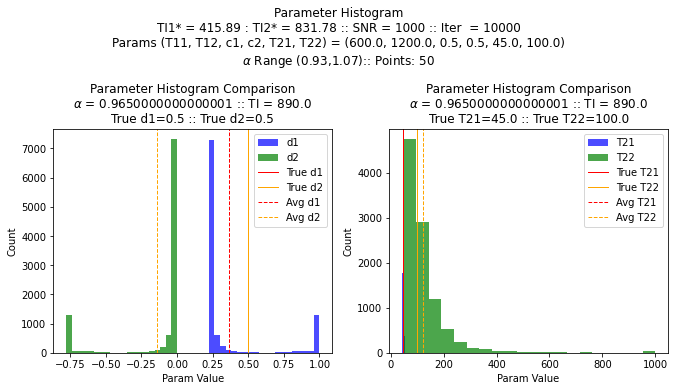

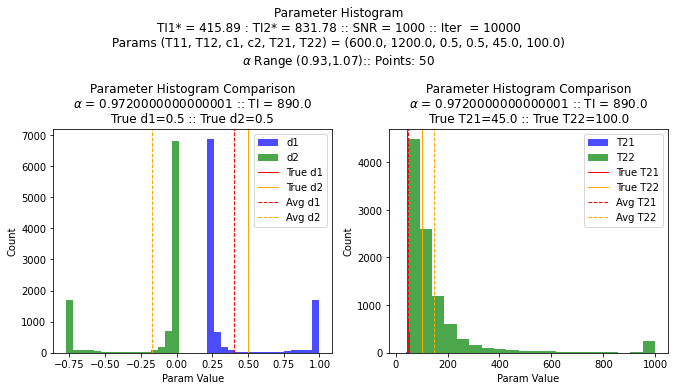

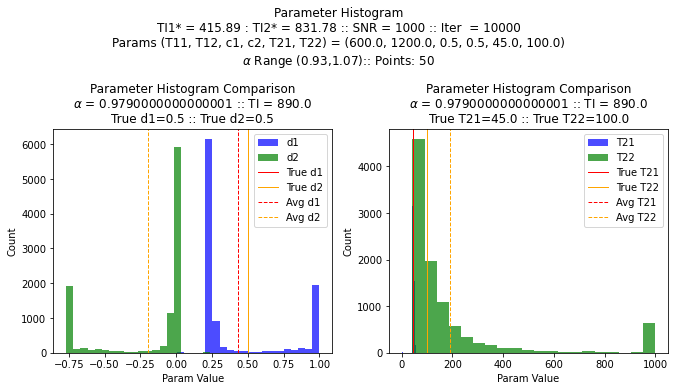

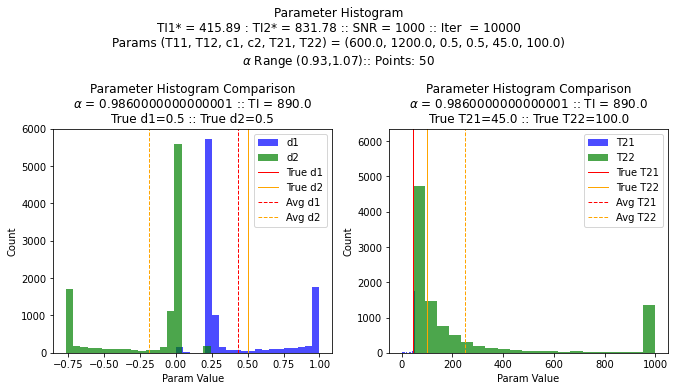

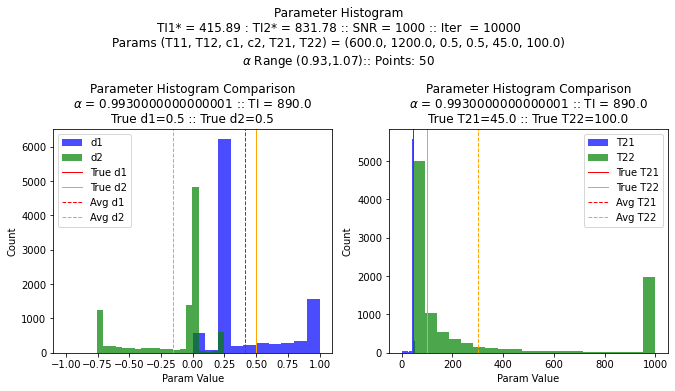

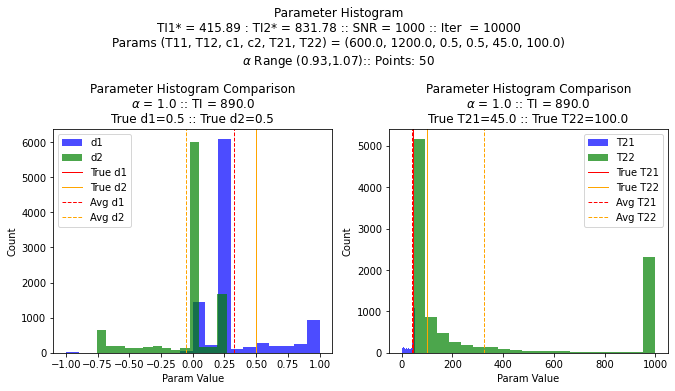

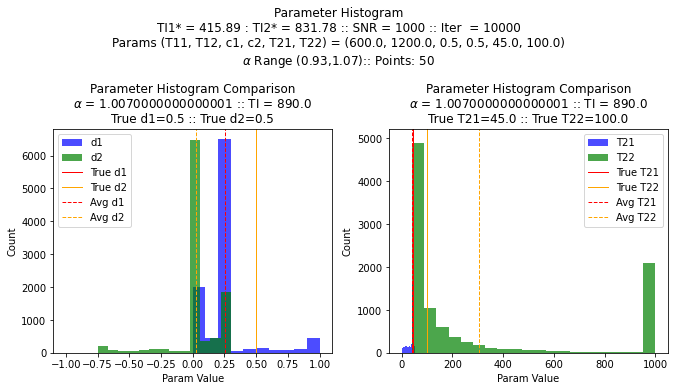

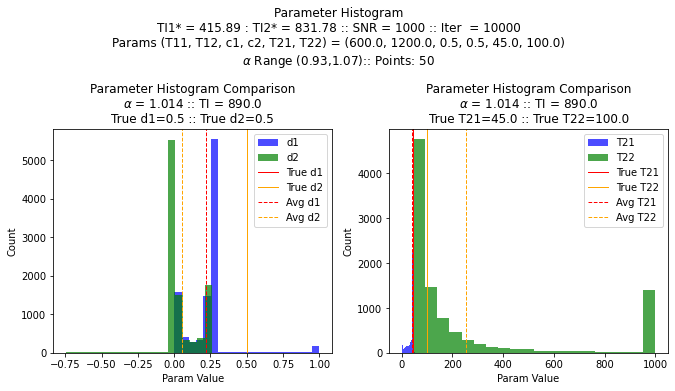

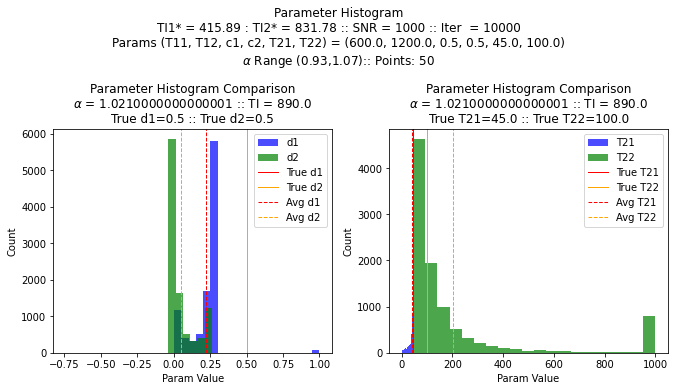

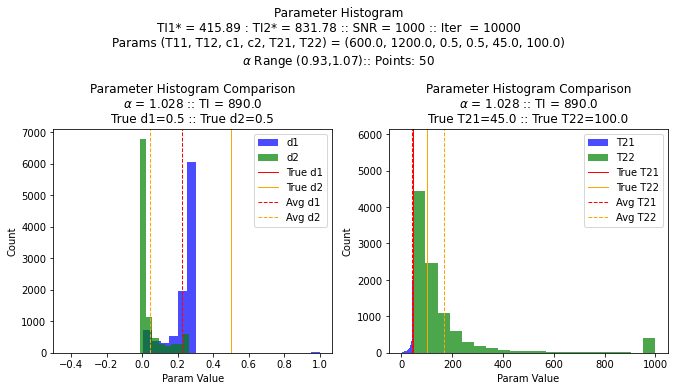

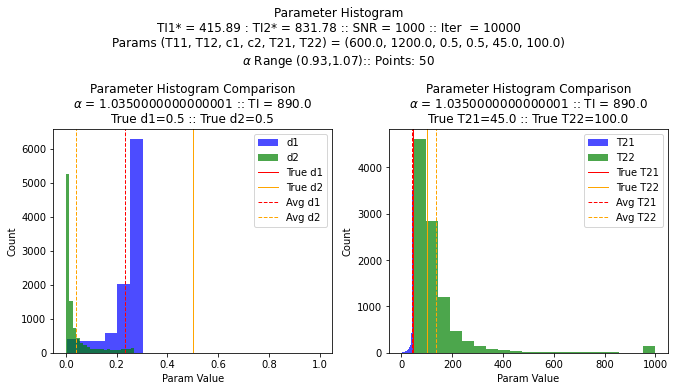

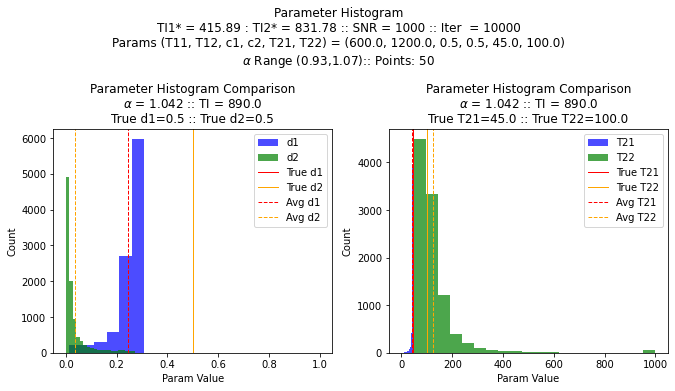

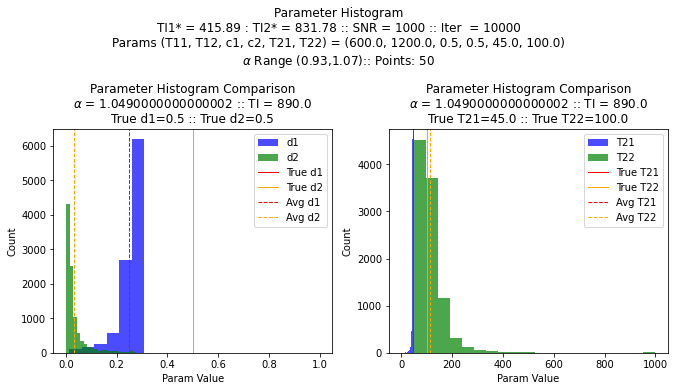

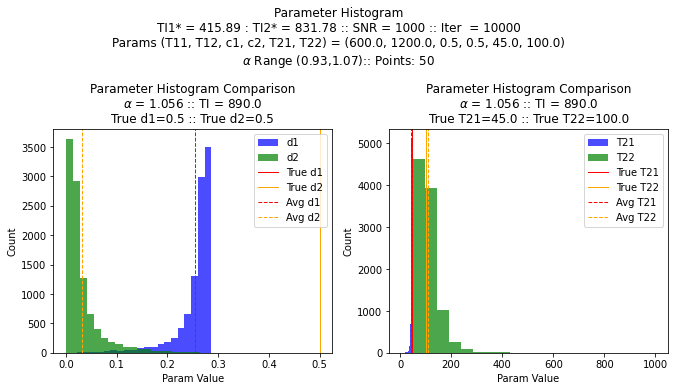

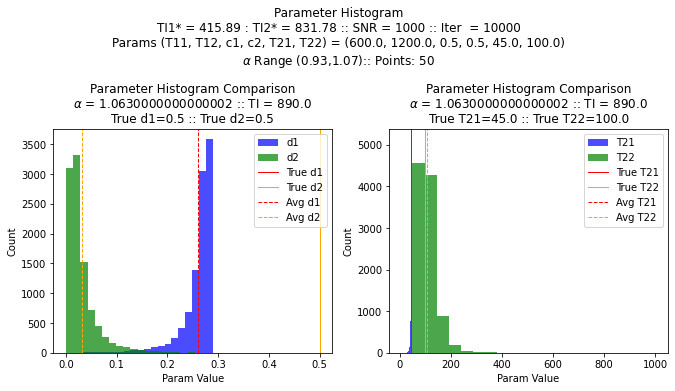

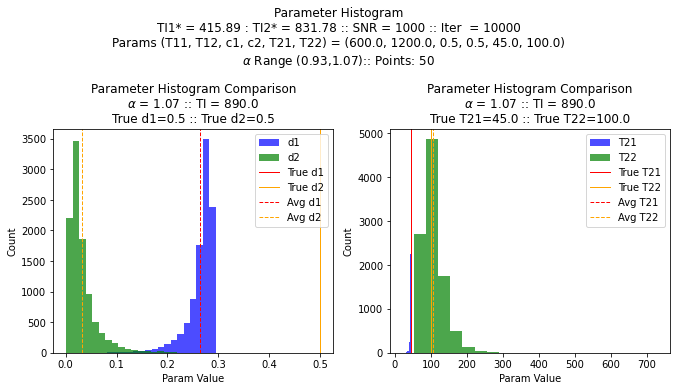

In [7]:
if histPlot:
    for k in range(paramStore_2E.shape[0]):
        paramData = paramStore_2E[k,:,:]
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        fig.suptitle("Parameter Histogram" + details)
        for ii in range(2):
            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramData[:,2*ii], bins=20, color='b', label = estParams[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramData[:,2*ii+1], bins=20, color='g', label = estParams[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=realParams[2*ii], linewidth=1, label= 'True ' + estParams[2*ii], color='red')
            ax[ii].axvline(x=realParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='orange')
            ax[ii].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParams[2*ii], color='red', ls = "--")
            ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='orange', ls = "--")
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) +
                        '\nTrue ' + estParams[2*ii] + '=' + str(round(realParams[2*ii],2)) + ' :: ' 
                        'True ' + estParams[2*ii+1] + '=' + str(round(realParams[2*ii+1],2)))
        plt.show()

### Density Plot of Signals

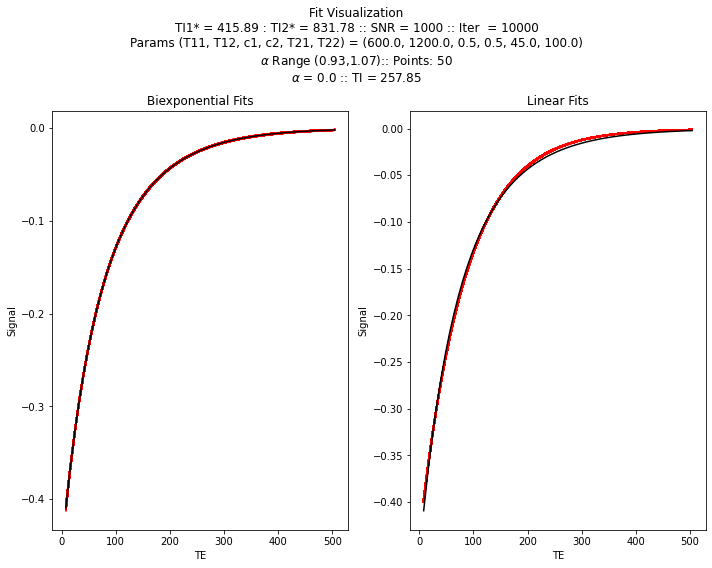

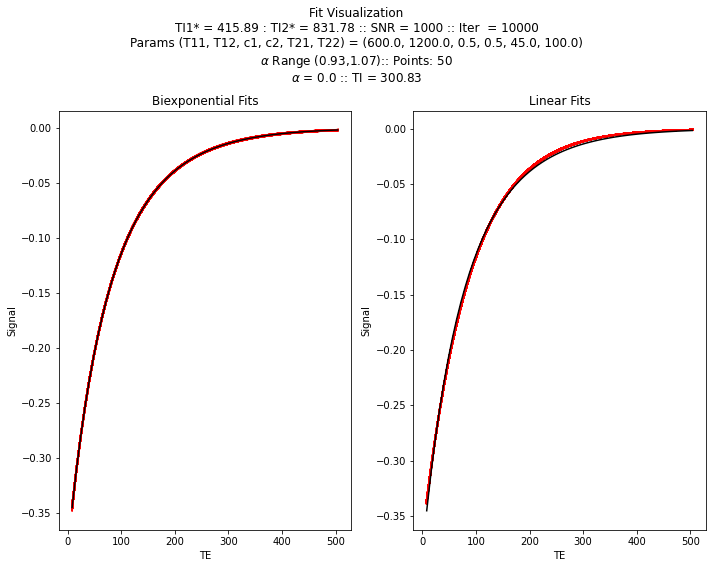

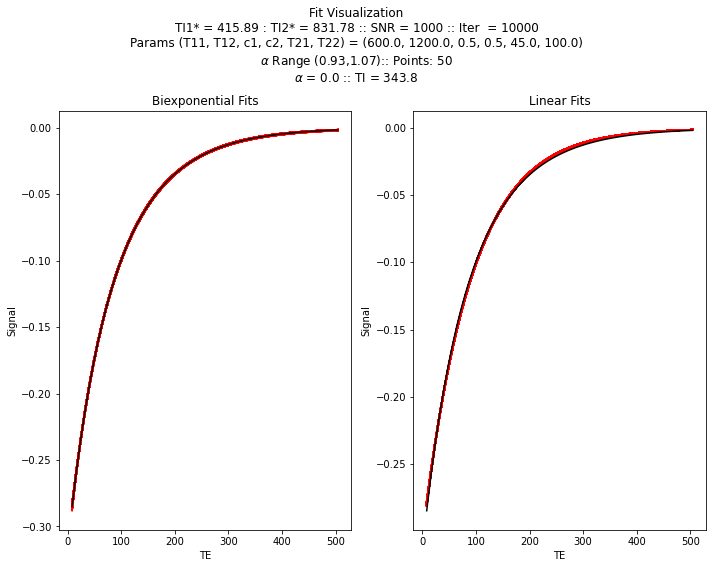

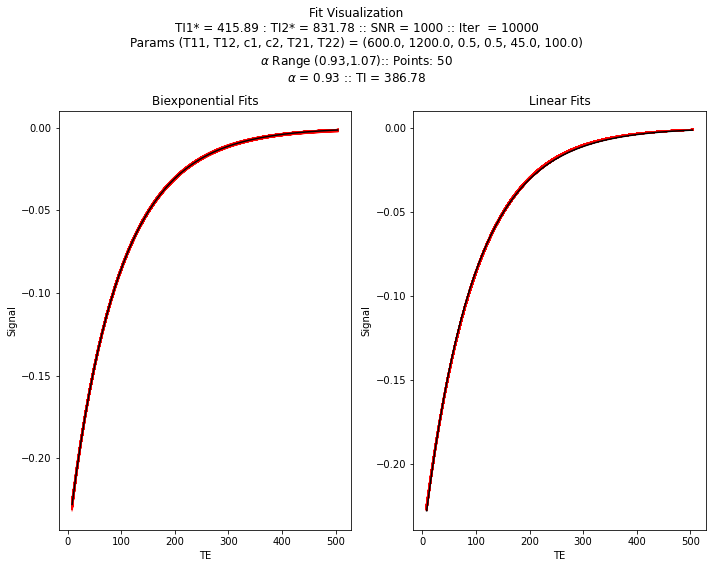

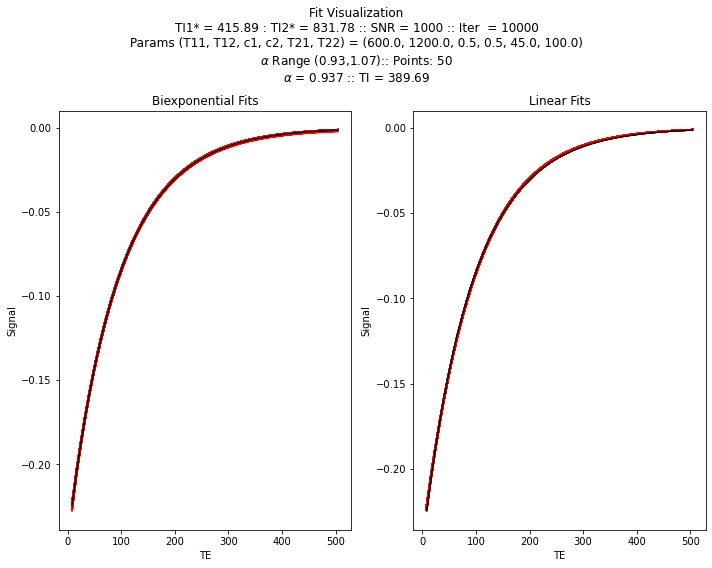

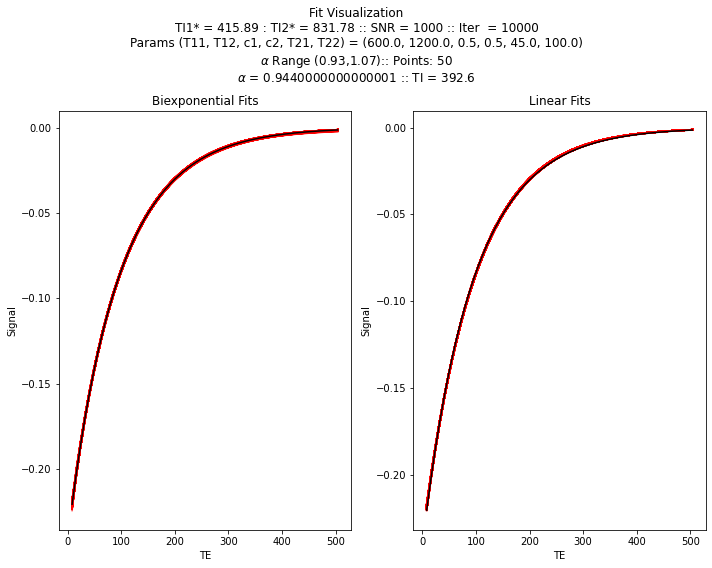

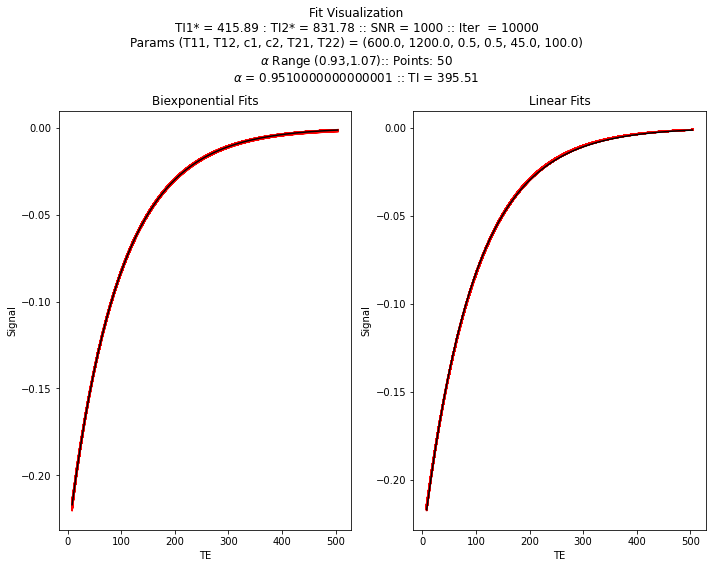

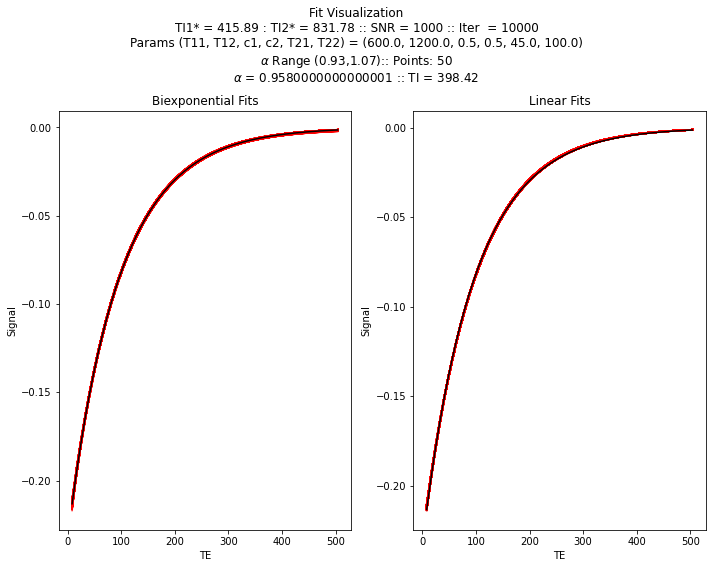

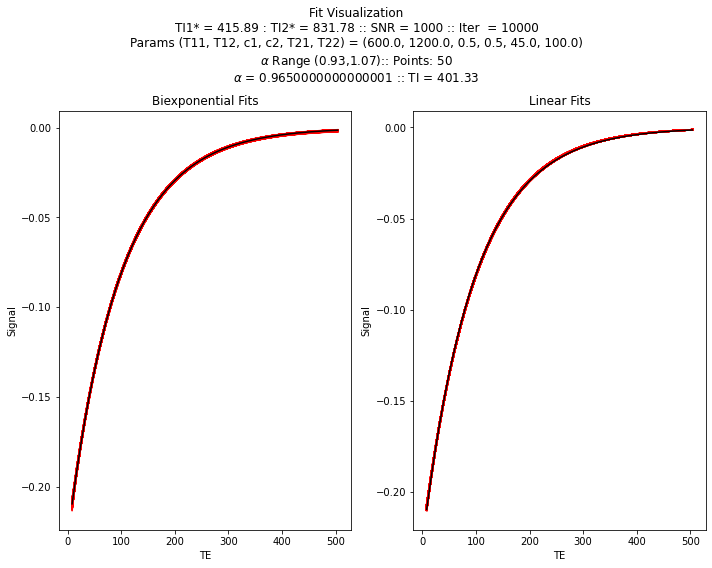

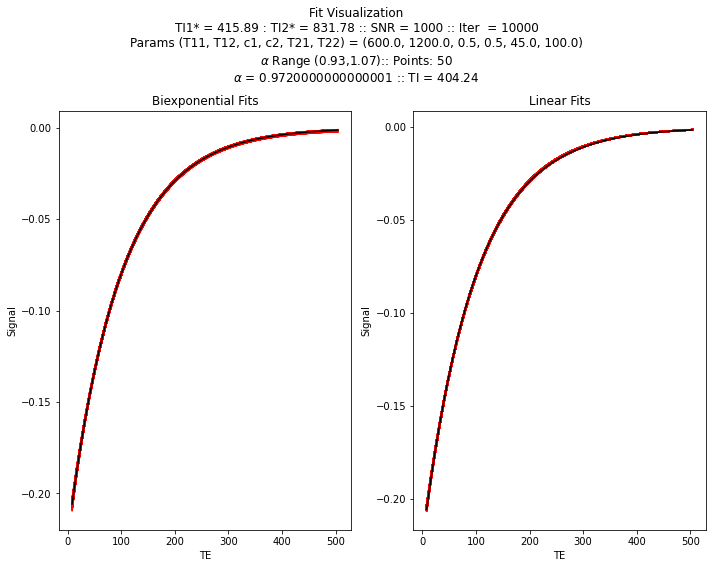

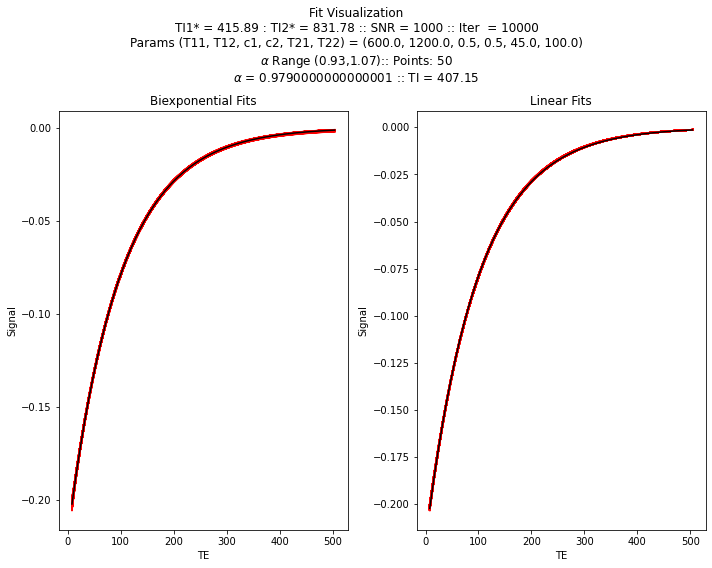

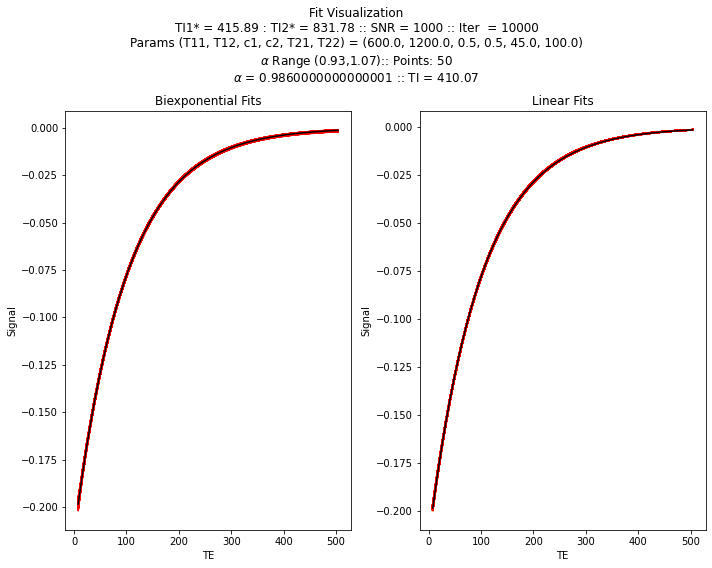

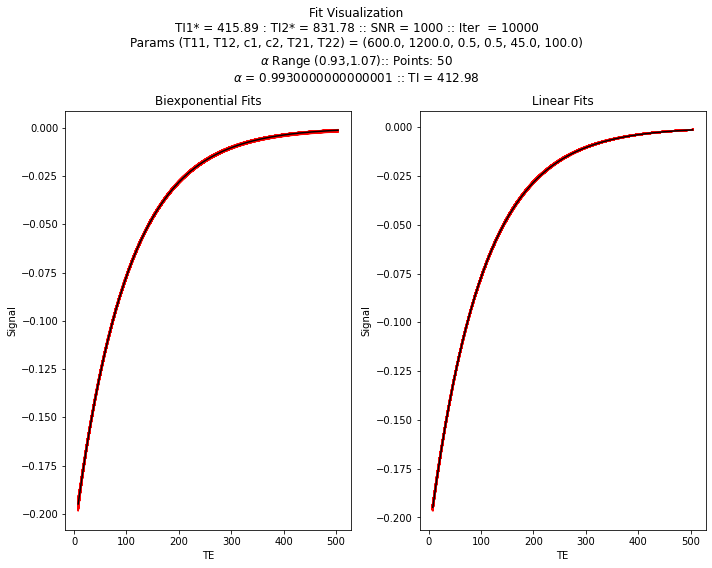

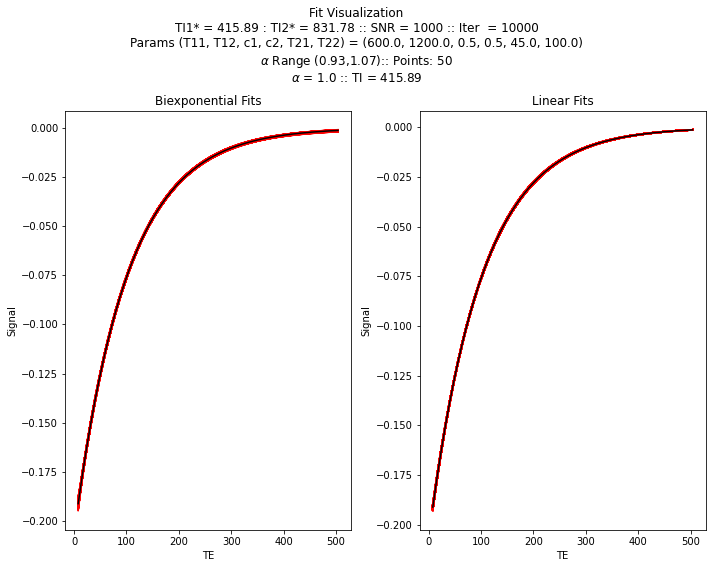

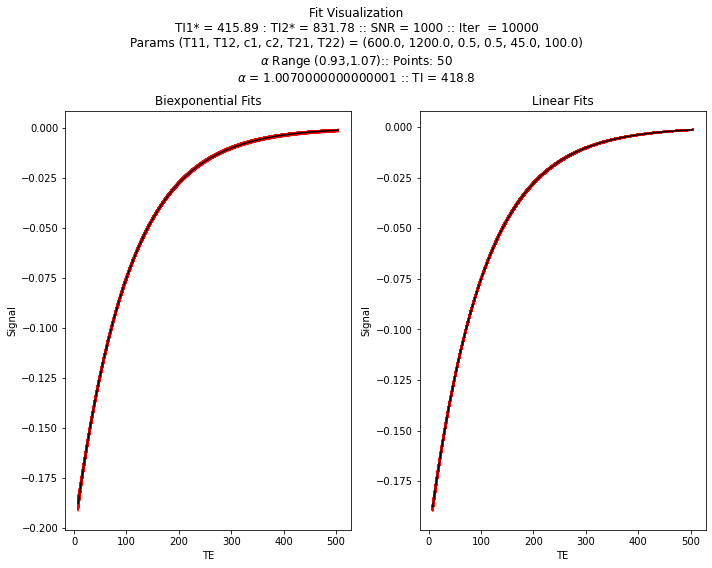

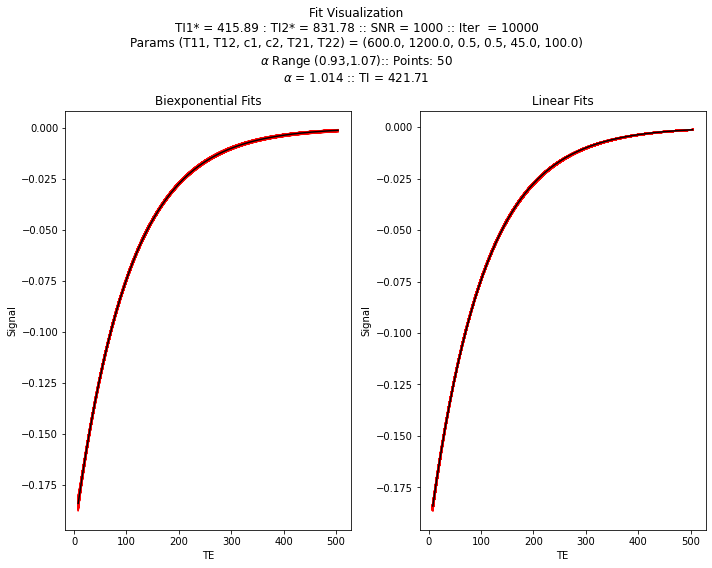

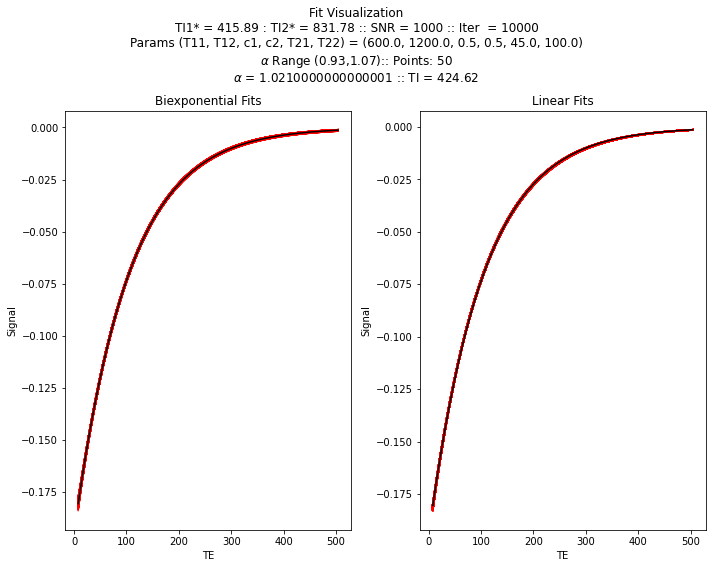

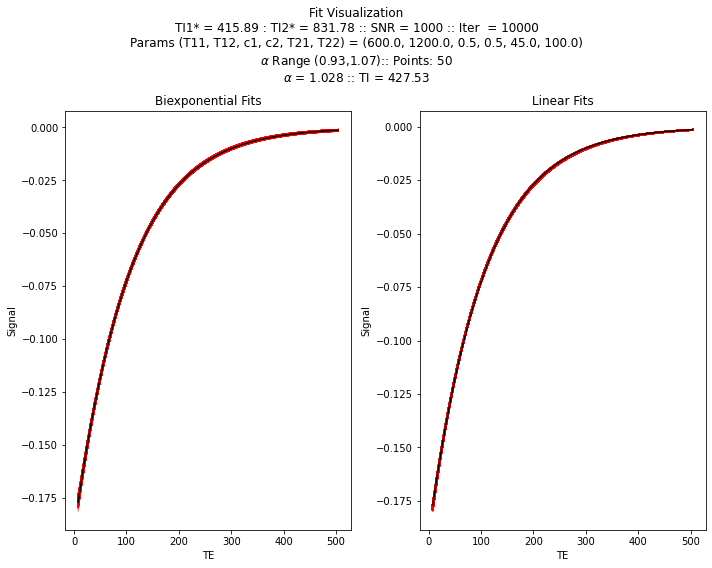

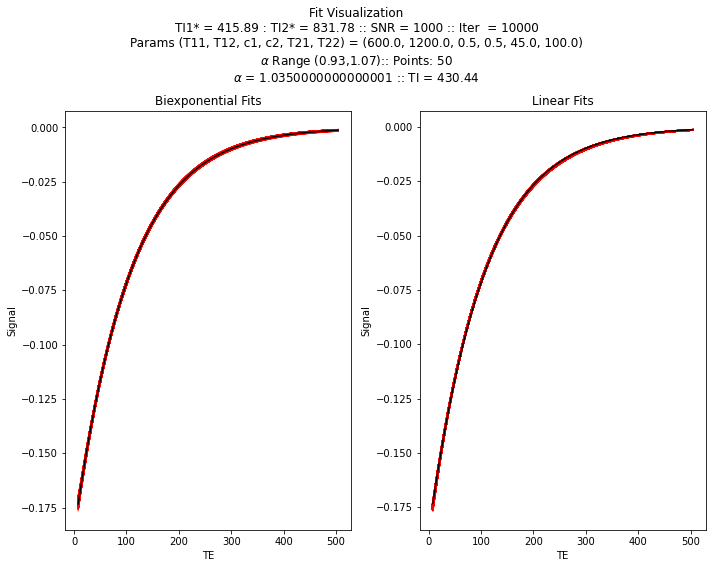

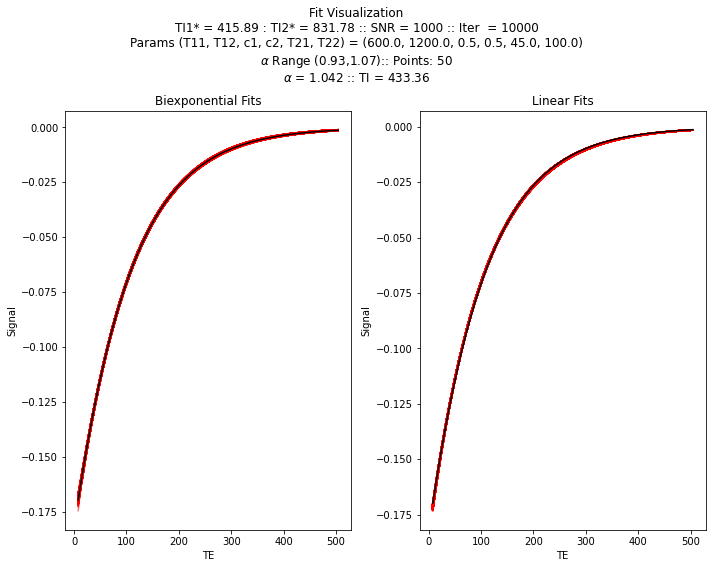

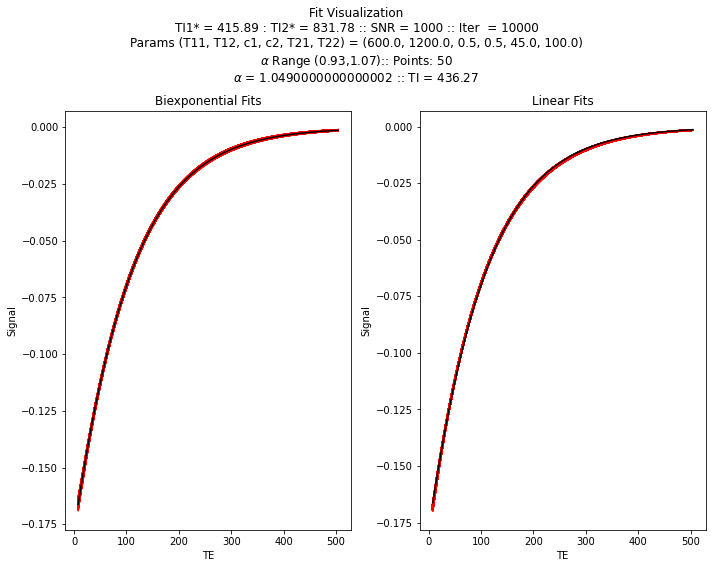

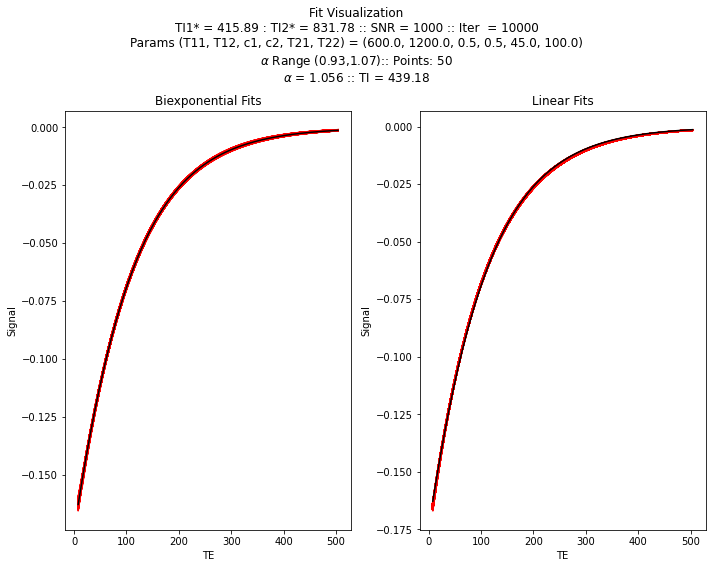

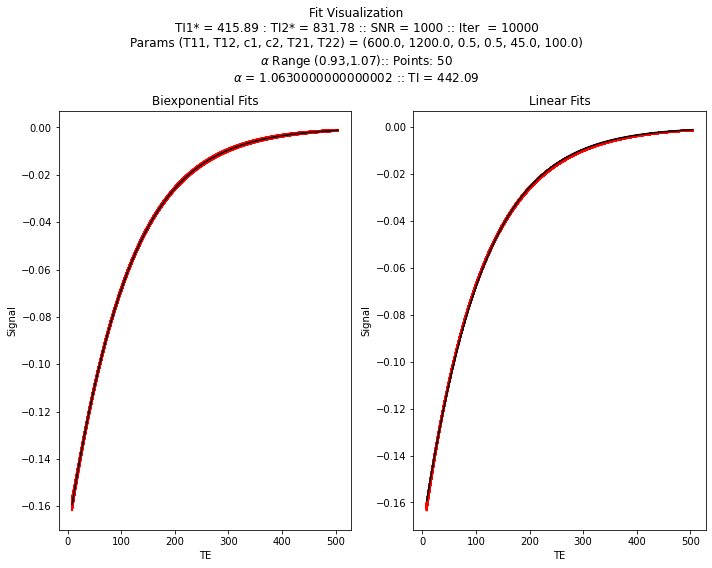

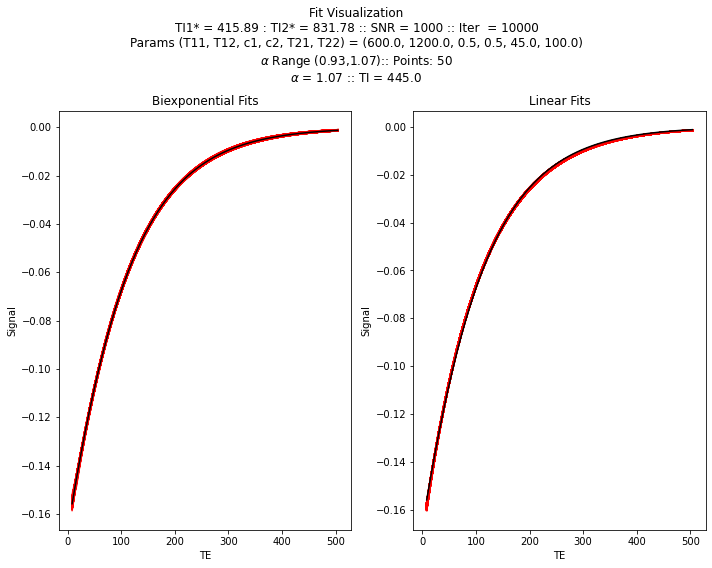

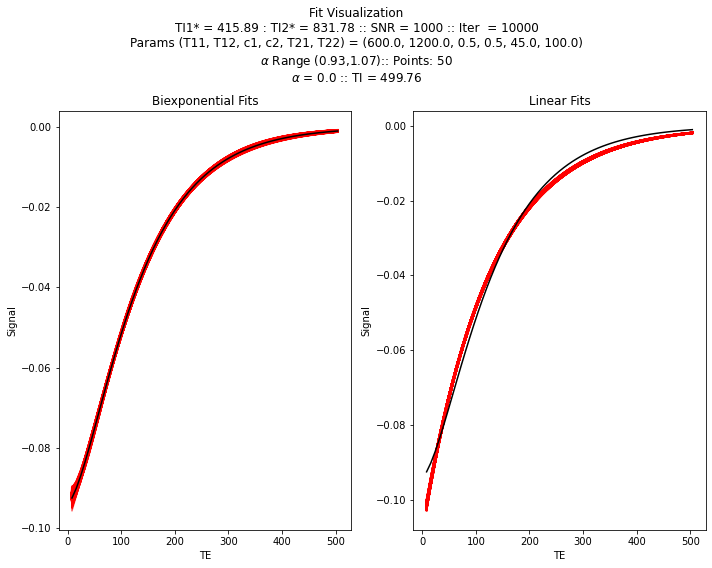

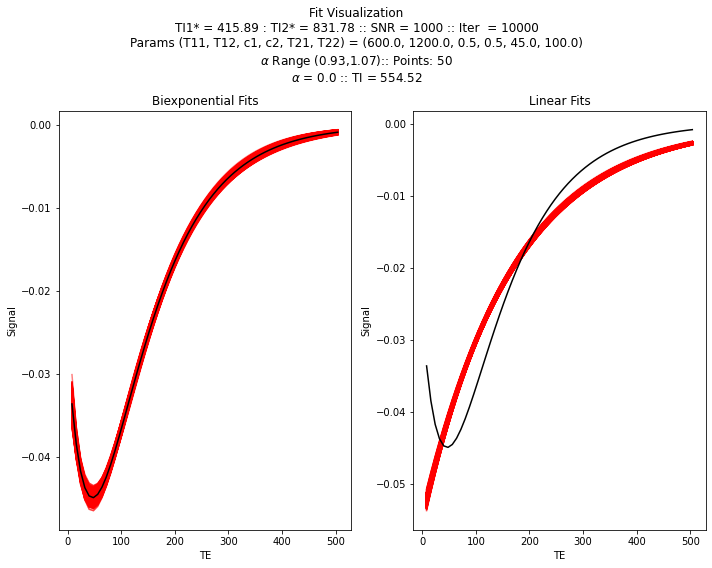

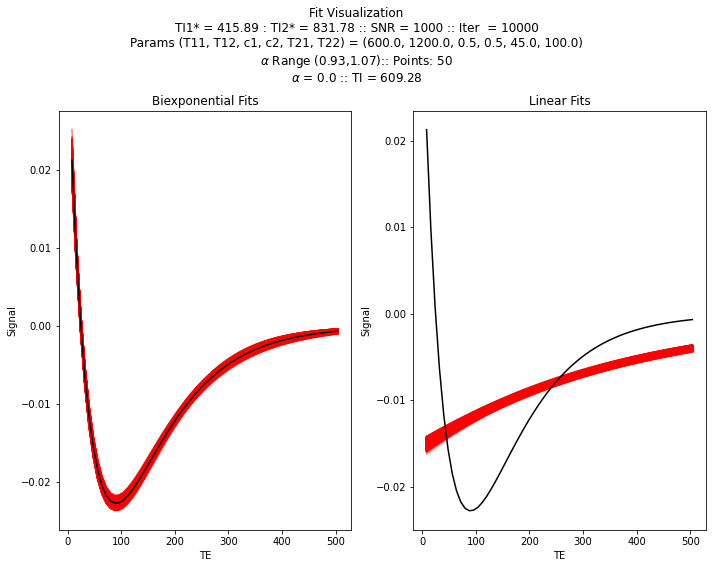

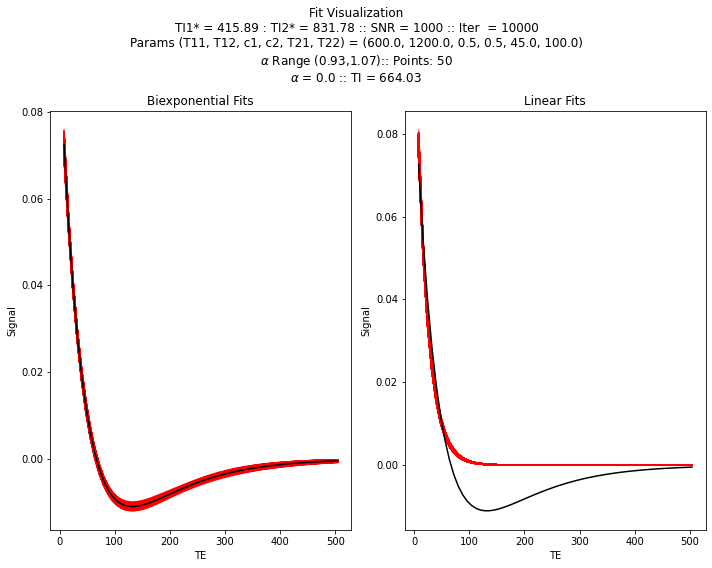

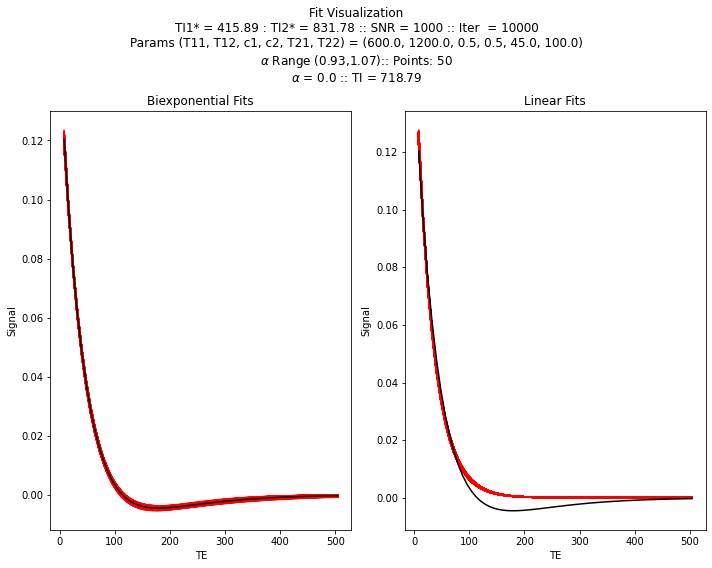

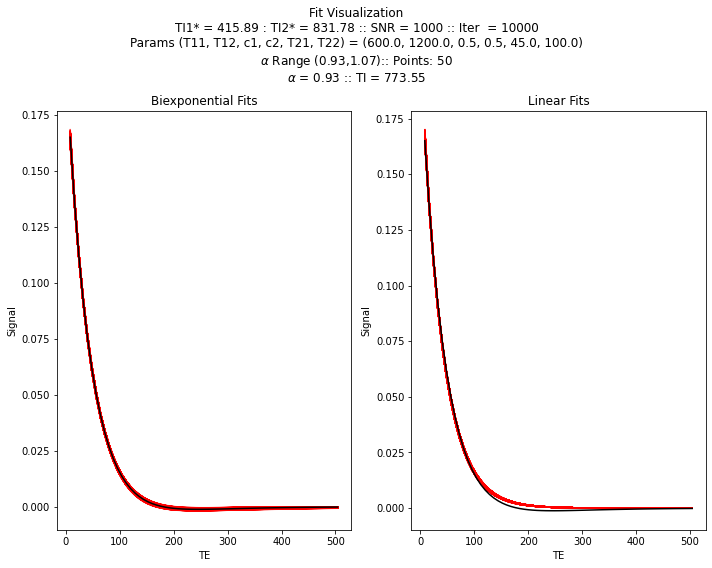

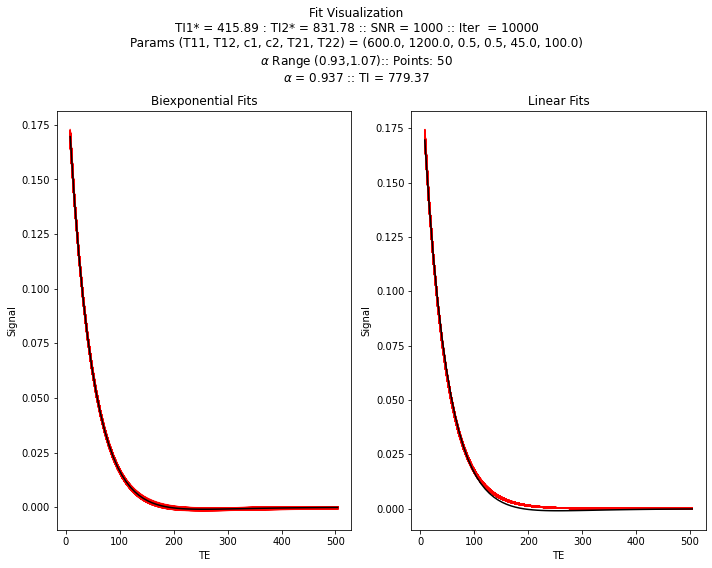

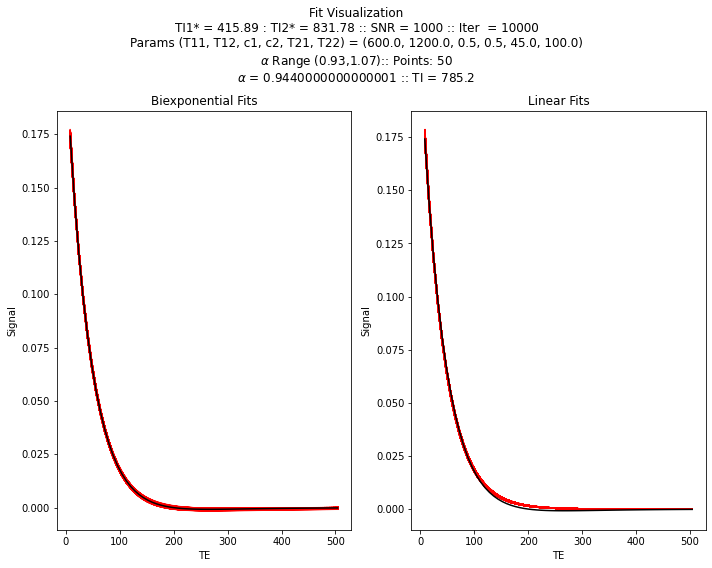

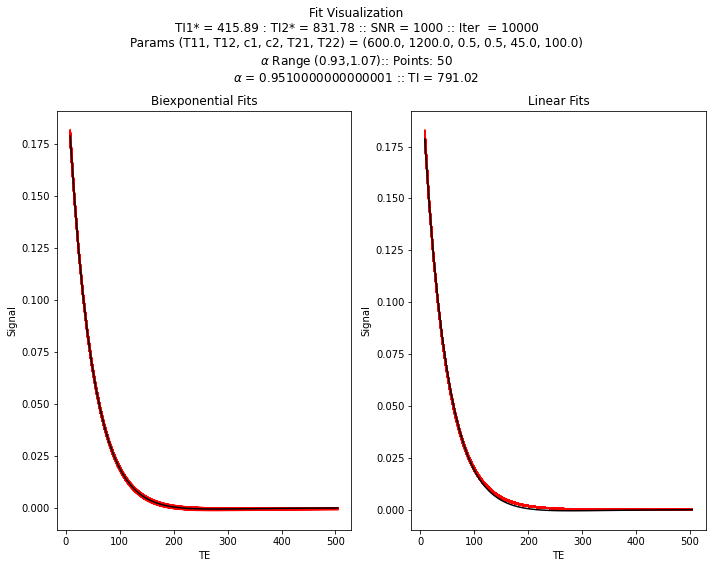

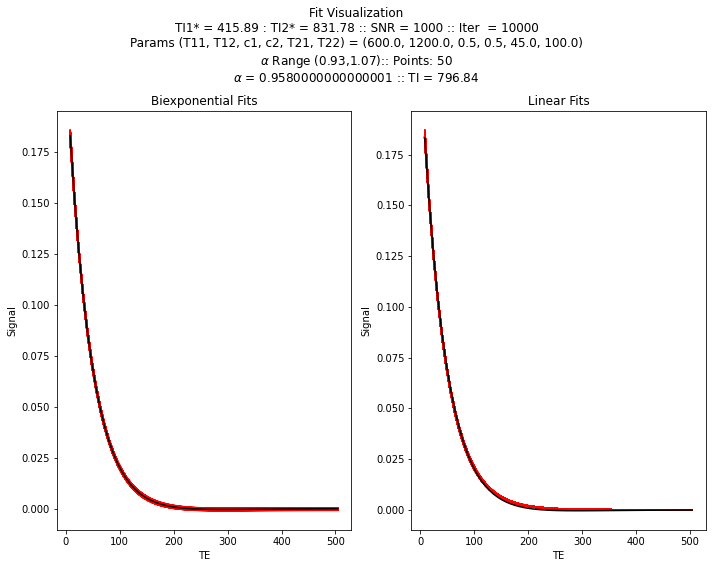

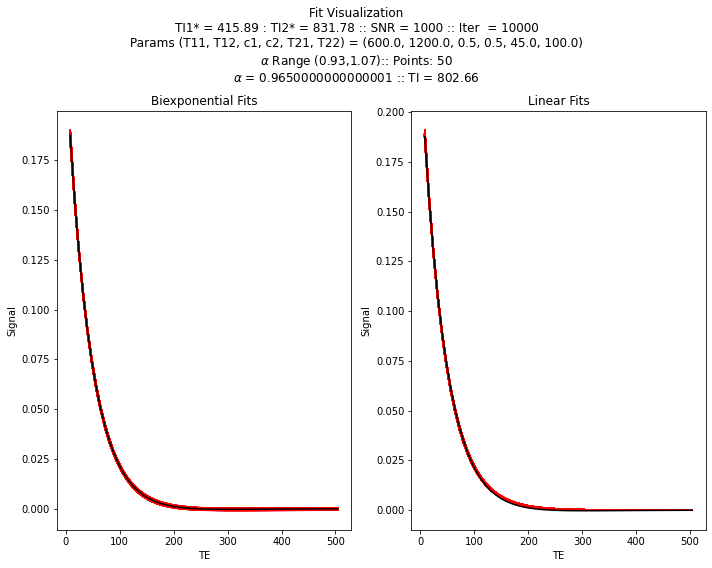

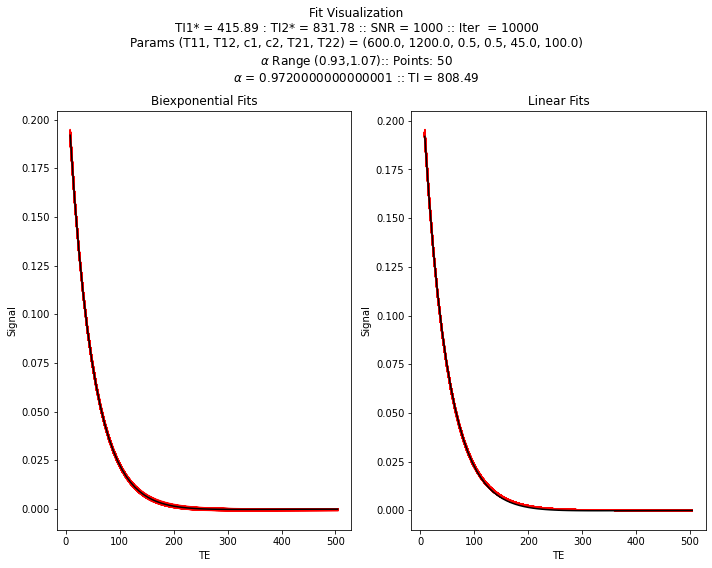

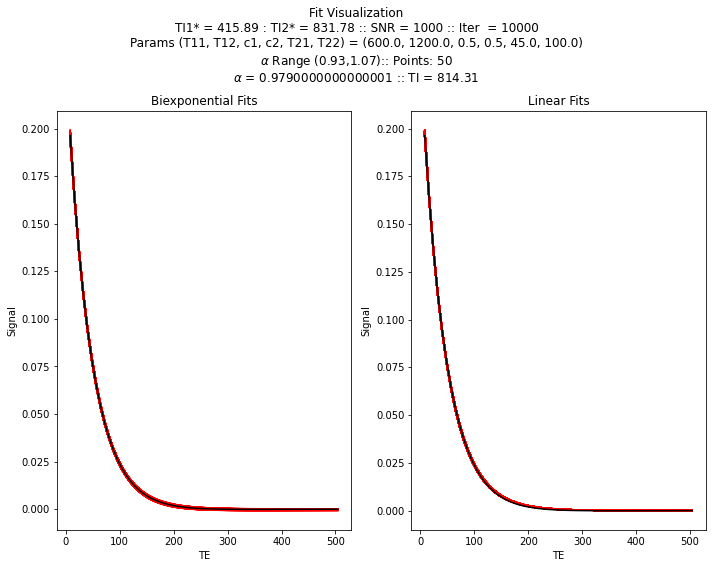

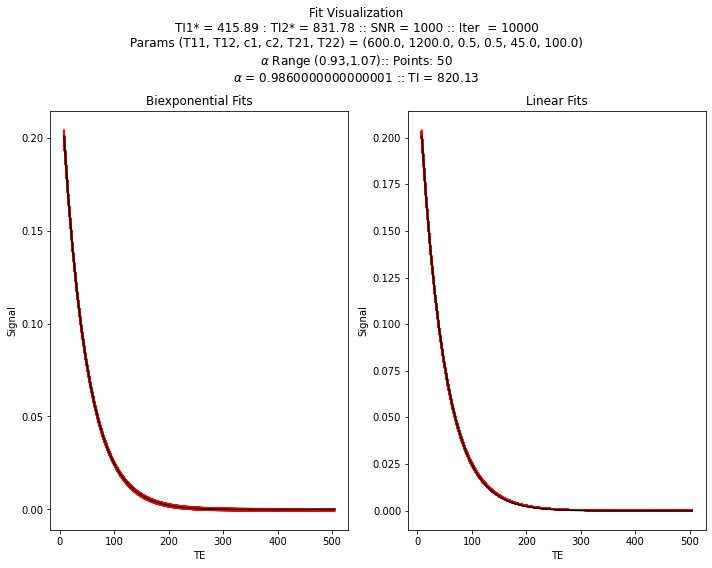

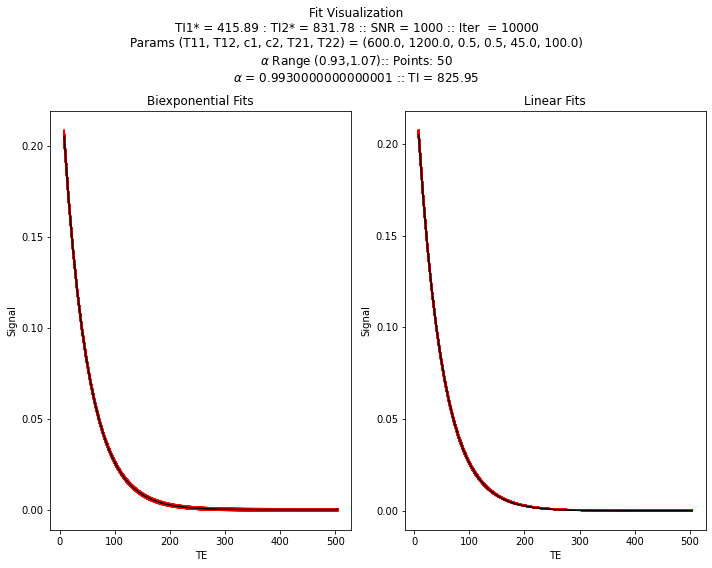

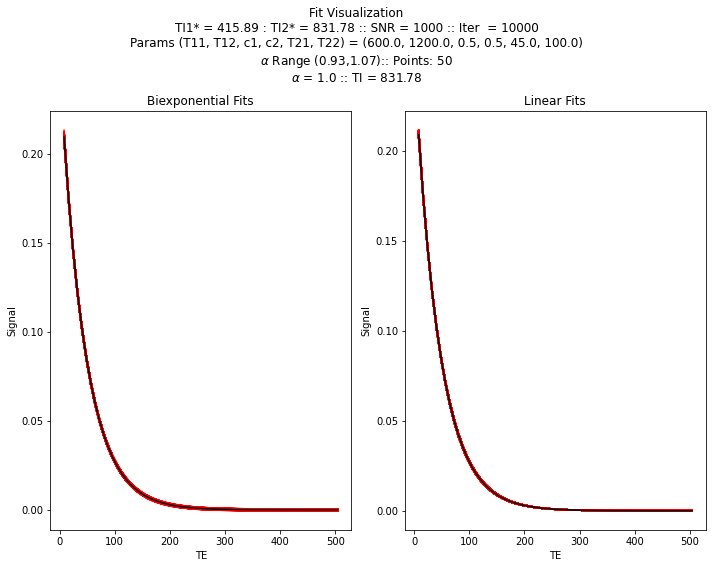

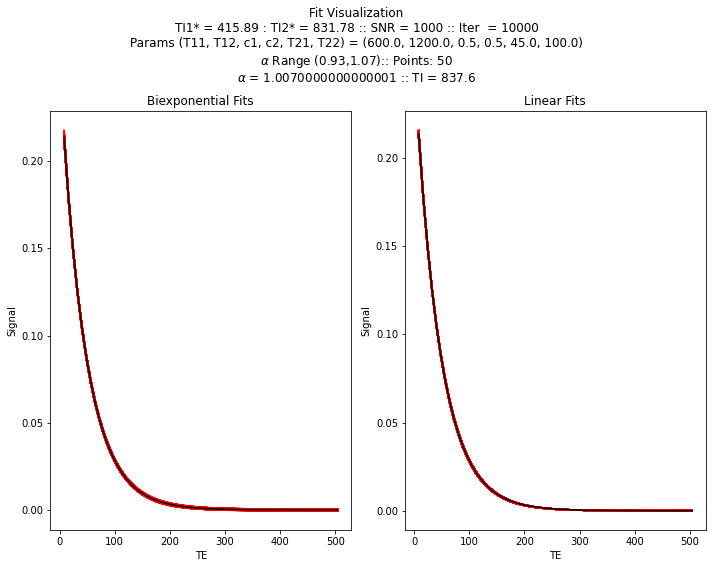

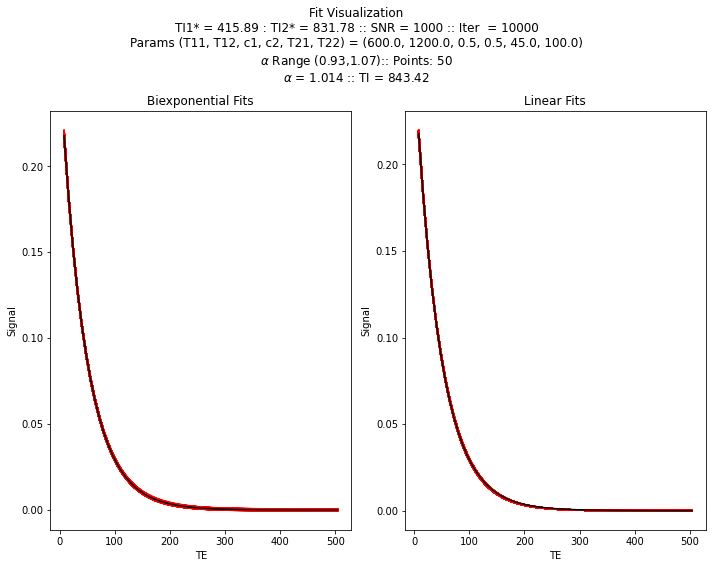

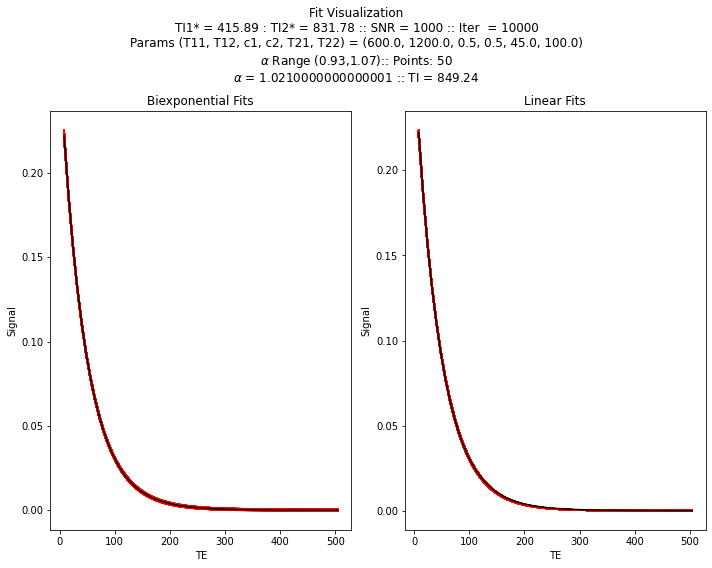

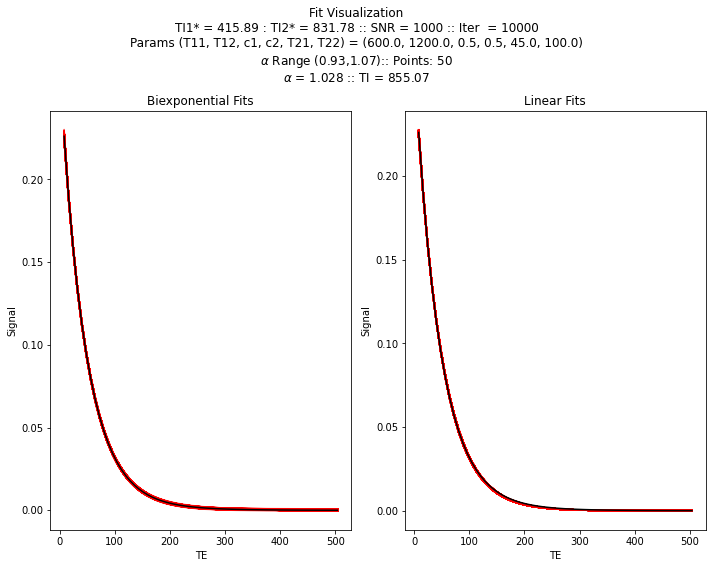

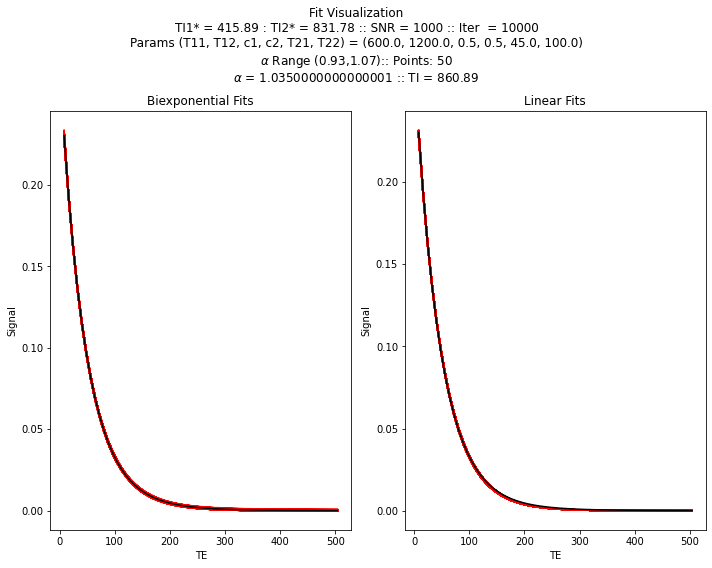

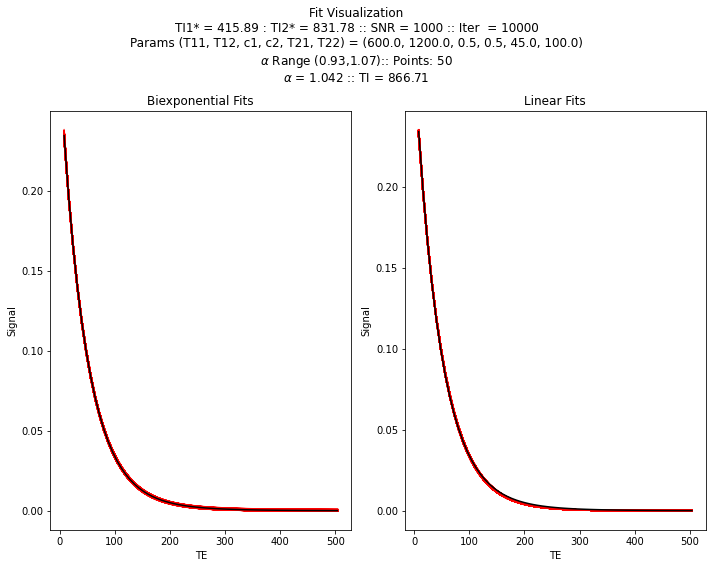

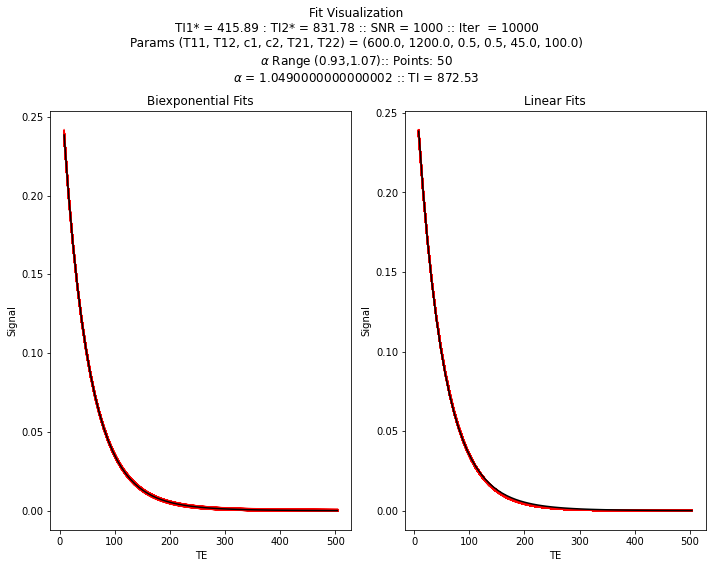

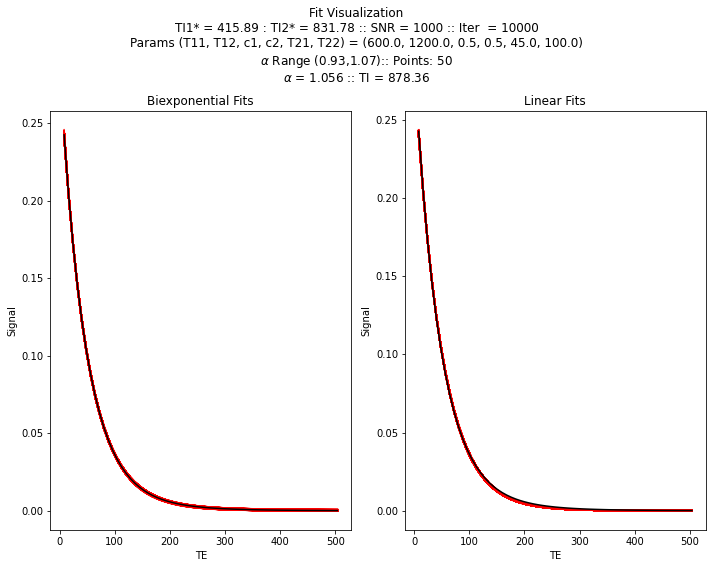

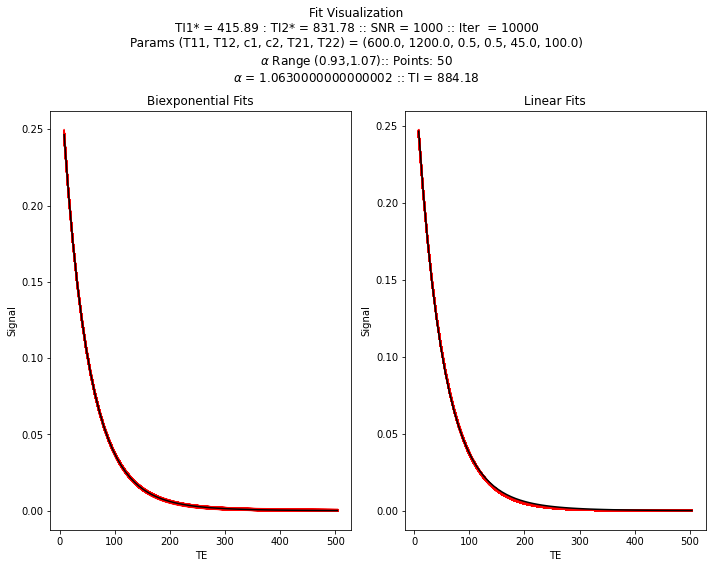

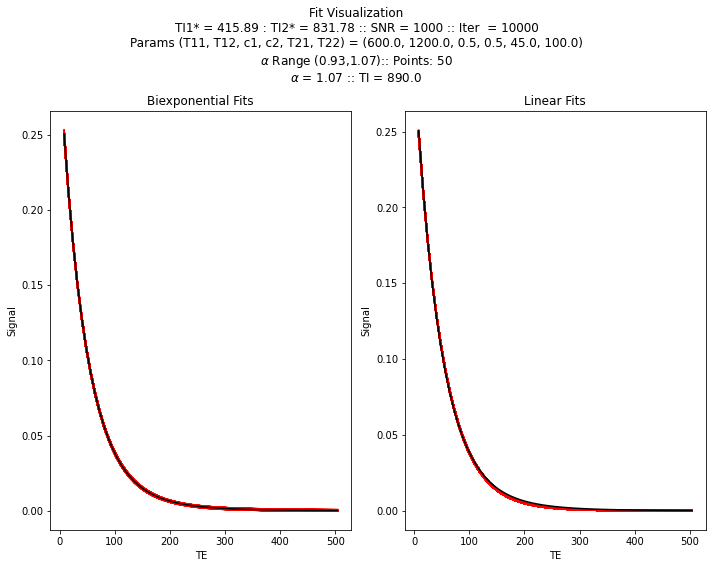

In [8]:
if denPlot:
    for k in range(paramStore_2E.shape[0]):

        TI = TI_array[k]
        trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

        fig, ax = plt.subplots(1,2, figsize=(10,8), tight_layout=True)

        fig.suptitle('Fit Visualization' + details + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)))
        
        for rep in range(iterCount):
            ax[0].plot(TE_series, sigStore_2E[k,rep,:], color='r', alpha = 0.5)
            ax[1].plot(TE_series, sigStore_1E[k,rep,:], color='r', alpha = 0.5)

        ax[0].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
        ax[1].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)

        ax[0].set_xlabel("TE")
        ax[1].set_xlabel("TE")
        ax[0].set_ylabel("Signal")
        ax[1].set_ylabel("Signal")
        ax[0].set_title("Biexponential Fits")
        ax[1].set_title("Linear Fits")

        plt.show()

### Standard Deviation

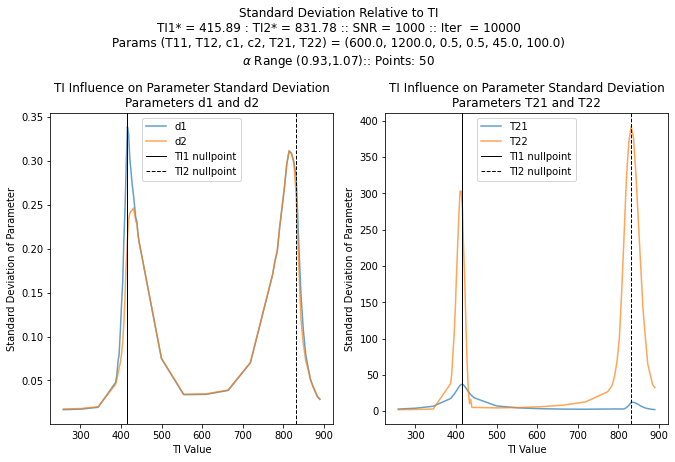

In [9]:
if stdPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    fig.suptitle('Standard Deviation Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array,stdStore[:,2*i], label = estParams[2*i], alpha = 0.7)
        ax[i].plot(TI_array,stdStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7)
        # ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Standard Deviation of Parameter')
        ax[i].set_title('TI Influence on Parameter Standard Deviation' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
        ax[i].legend()
    plt.show()

### Condition Number Plots

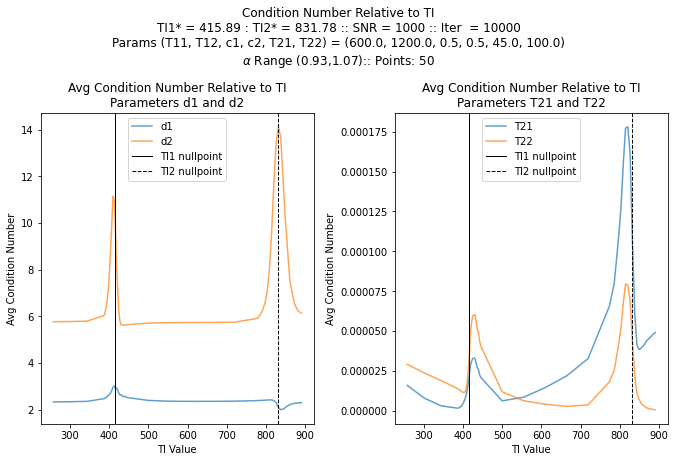

C:\Users\griff\AppData\Local\Temp\ipykernel_8648\2104559762.py:17: RuntimeWarning: divide by zero encountered in divide
  CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run
C:\Users\griff\AppData\Local\Temp\ipykernel_8648\2104559762.py:17: RuntimeWarning: invalid value encountered in divide
  CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run


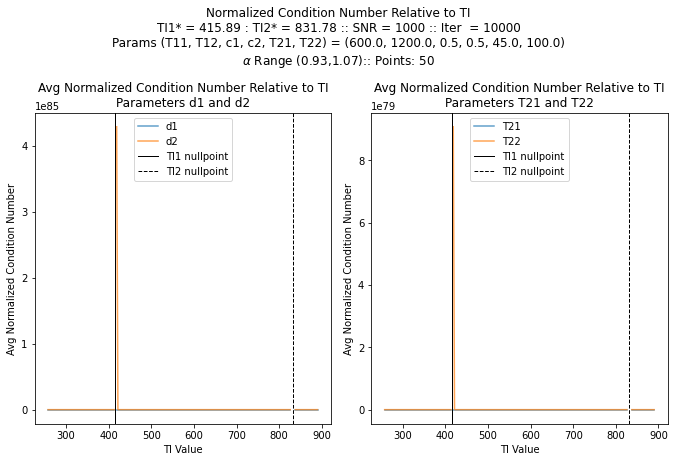

In [10]:
if cNPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    fig.suptitle('Condition Number Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array,avgCNStore[:,2*i], label = estParams[2*i], alpha = 0.7)
        ax[i].plot(TI_array,avgCNStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Avg Condition Number')
        ax[i].set_title('Avg Condition Number Relative to TI' +
                            '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
        ax[i].legend()
    plt.show()


CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run
CN_normalized = np.mean(CN_normalized, axis = 1)


fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
fig.suptitle('Normalized Condition Number Relative to TI' + details)
for i in range(2):
    ax[i].plot(TI_array,CN_normalized[:,2*i], label = estParams[2*i], alpha = 0.7)
    ax[i].plot(TI_array,CN_normalized[:,2*i+1], label = estParams[2*i+1], alpha = 0.7)
    ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
    ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
    ax[i].set_xlabel('TI Value')
    ax[i].set_ylabel('Avg Normalized Condition Number')
    # ax[i].set_ylim([0,10])
    ax[i].set_title('Avg Normalized Condition Number Relative to TI' +
                        '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
    ax[i].legend()
plt.show()

### Residual Sum of Squares Plot

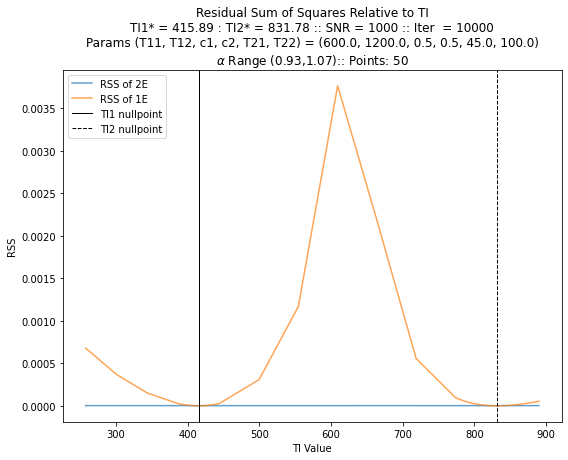

In [11]:
RSS_avg = np.mean(RSS_Store,axis = 1)
RSS_avg_1E = np.mean(RSS_Store_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,RSS_avg, label = 'RSS of 2E', alpha = 0.7)
plt.plot(TI_array,RSS_avg_1E, label = 'RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Residual Sum of Squares Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

### L2 Norm Plot

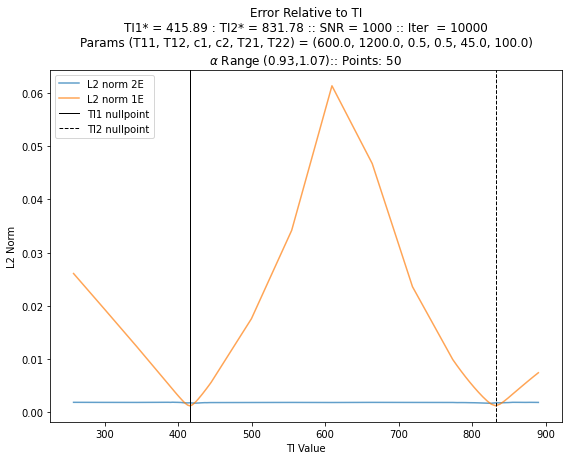

In [12]:
Err_avg = np.mean(errStore,axis = 1)
Err_avg_1E = np.mean(errStore_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,Err_avg, label = 'L2 norm 2E', alpha = 0.7)
plt.plot(TI_array,Err_avg_1E, label = 'L2 norm 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('L2 Norm')
plt.title('Error Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

### Information Criteria - AIC, BIC, R2, Cp

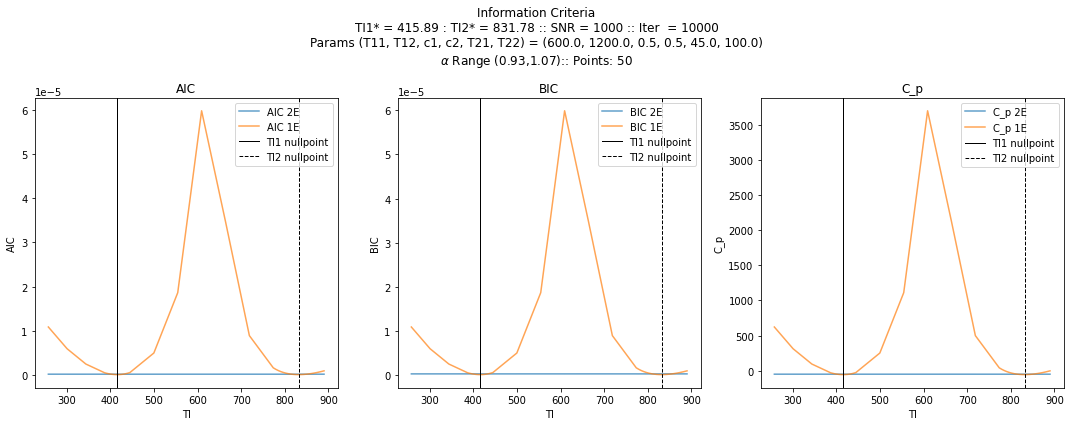

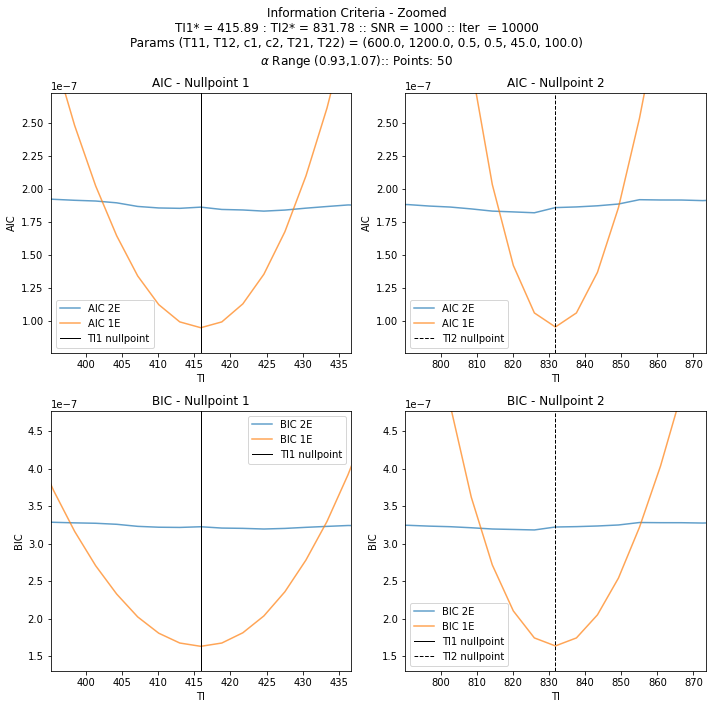

In [13]:
AIC_2E = 1/TE_series.shape[0] * (RSS_avg + 2 * np.size(estParams)*noiseSigma**2)
AIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + 2 * np.size(MonoTitle)*noiseSigma**2)

BIC_2E = 1/TE_series.shape[0] * (RSS_avg + np.log(TE_series.shape[0]) * np.size(estParams)*noiseSigma**2)
BIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + np.log(TE_series.shape[0]) * np.size(MonoTitle)*noiseSigma**2)

Cp_2E = RSS_avg/noiseSigma**2 + 2*np.size(estParams) - TE_series.shape[0]
Cp_1E = RSS_avg_1E/noiseSigma**2 + 2*np.size(MonoTitle) - TE_series.shape[0]

fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
fig.suptitle('Information Criteria' + details)


ax[0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0].set_title('AIC')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('AIC')
ax[0].legend()

ax[1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1].set_title('BIC')
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('BIC')
ax[1].legend()

ax[2].plot(TI_array, Cp_2E, label = 'C_p 2E', alpha = 0.7)
ax[2].plot(TI_array, Cp_1E, label = 'C_p 1E', alpha = 0.7)
ax[2].set_title('C_p')
ax[2].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[2].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[2].set_xlabel('TI')
ax[2].set_ylabel('C_p')
ax[2].legend()

fig, ax = plt.subplots(2,2,figsize=(10,10), tight_layout=True)
fig.suptitle('Information Criteria - Zoomed' + details)

minVal_1E = min(AIC_1E)
minVal_2E = min(AIC_2E)
ax[0,0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0,0].set_title('AIC - Nullpoint 1')
ax[0,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0,0].set_xlabel('TI')
ax[0,0].set_ylabel('AIC')
ax[0,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,0].set_xlim([(1-rad)*TI1star, (1+rad)*TI1star])
ax[0,0].legend()

ax[0,1].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,1].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0,1].set_title('AIC - Nullpoint 2')
ax[0,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0,1].set_xlabel('TI')
ax[0,1].set_ylabel('AIC')
ax[0,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,1].set_xlim([(1-rad)*TI2star, (1+rad)*TI2star])
ax[0,1].legend()

minVal_1E = min(BIC_1E)
minVal_2E = min(BIC_2E)
ax[1,0].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,0].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1,0].set_title('BIC - Nullpoint 1')
ax[1,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,0].set_xlabel('TI')
ax[1,0].set_ylabel('BIC')
ax[1,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,0].set_xlim([(1-rad)*TI1star, (1+rad)*TI1star])
ax[1,0].legend()

ax[1,1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1,1].set_title('BIC - Nullpoint 2')
ax[1,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1,1].set_xlabel('TI')
ax[1,1].set_ylabel('BIC')
ax[1,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,1].set_xlim([(1-rad)*TI2star, (1+rad)*TI2star])
ax[1,1].legend()


### Rule Breaking Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


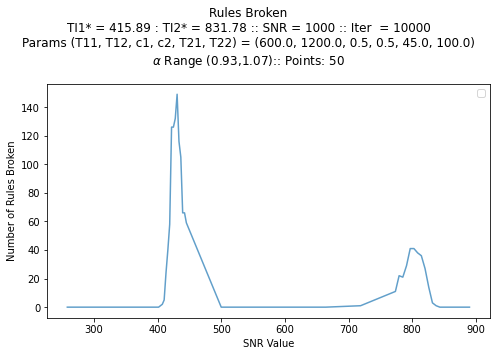

In [14]:
fig = plt.figure(figsize=(7,5), tight_layout=True)
fig.suptitle('Rules Broken' + details)
plt.plot(TI_array, numRuleBreak, alpha = 0.7)
plt.xlabel('SNR Value')
plt.ylabel('Number of Rules Broken')
# plt.title('Biexponential Model')
plt.legend()

### Sensitivity Graphs

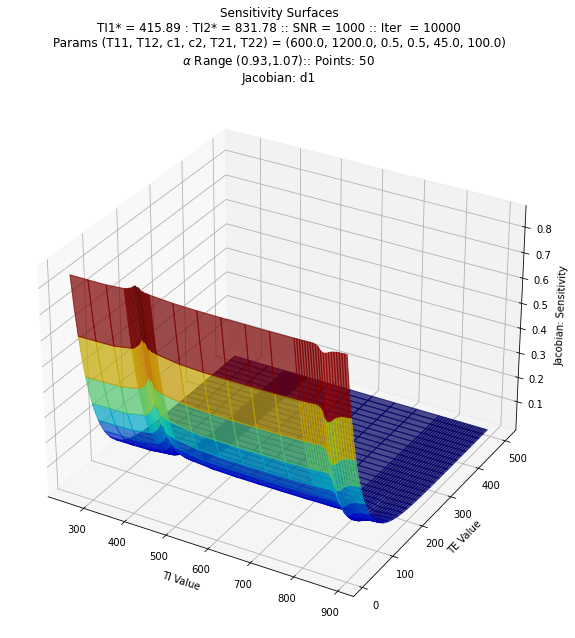

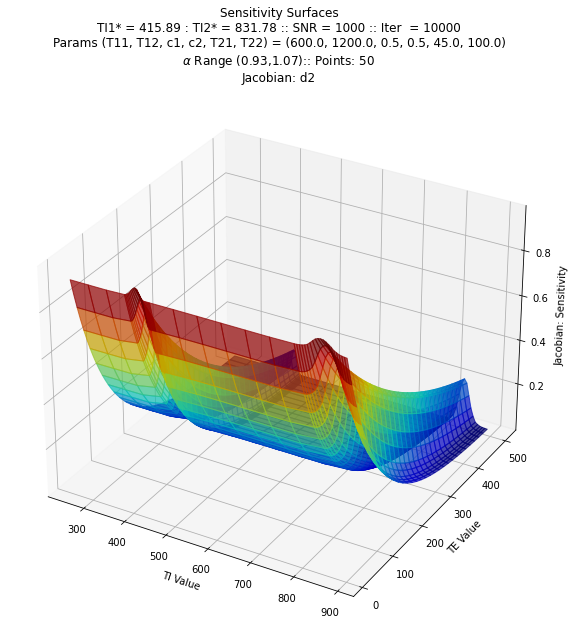

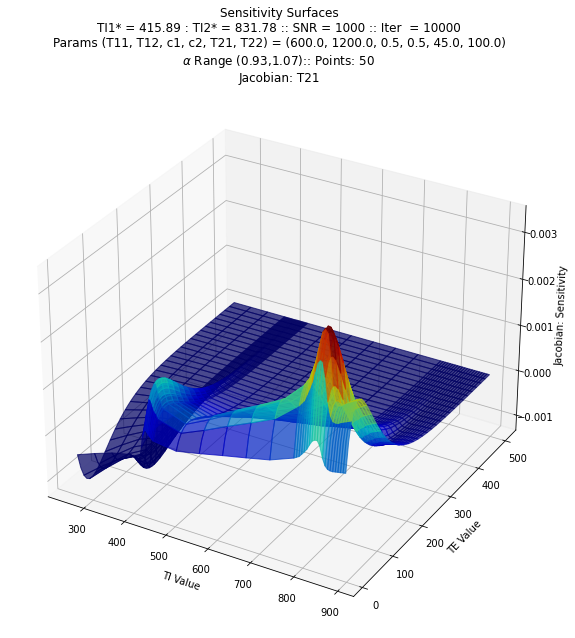

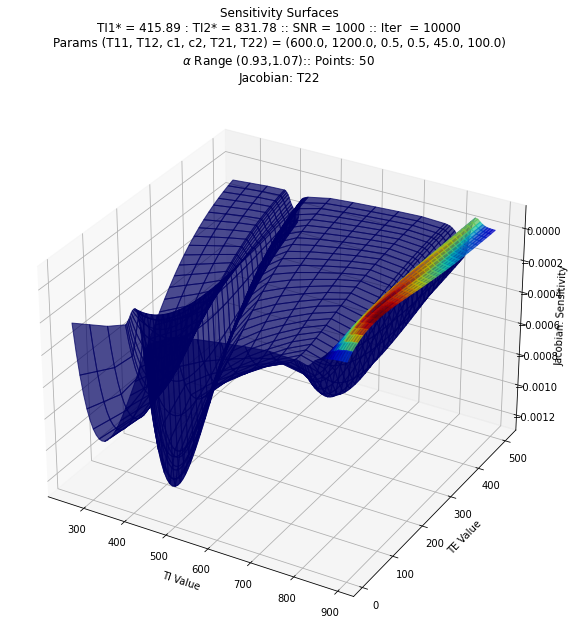

<Figure size 432x288 with 0 Axes>

In [17]:
TImg,TEmg = np.meshgrid(TI_array,TE_series)
if dModel:
    Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(ParamTitle_4p)))
else:
    Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(ParamTitle_6p)))
for i in range(Jstore.shape[0]):
    for j in range(Jstore.shape[1]):
        if dModel:
            Jstore[i,j,:] = Jacobian_4p(TEmg[i,j],*avgPStore[j,:])
        else:
            Jstore[i,j,:] = Jacobian_6p(TEmg[i,j],TImg[i,j],T11,T12,*avgPStore[j,:])
        



for j in range(Jstore.shape[2]):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    my_col = cm.jet(Jstore[:,:,j]/np.amax(Jstore[:,:,j]))
    ax.plot_surface(TImg,TEmg,Jstore[:,:,j], alpha = 0.7, facecolors = my_col)
    ax.set_xlabel('TI Value')
    ax.set_ylabel('TE Value')
    ax.set_zlabel('Jacobian: Sensitivity')
    if dModel:
        ax.set_title('Sensitivity Surfaces' + details + '\nJacobian: ' + ParamTitle_4p[j])
    else:
        ax.set_title('Sensitivity Surfaces' + details + '\nJacobian: ' + ParamTitle_6p[j])
    plt.show()



plt.tight_layout()
plt.show()